# Step 1: Environment Setup and Imports

In [ ]:
!pip install tab_transformer_pytorch
!pip install pytorch_tabnet
!pip install shap
!pip install imblearn
!pip install scikit-learn
!mkdir -p results 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve

from tab_transformer_pytorch import TabTransformer, FTTransformer
from pytorch_tabnet.tab_model import TabNetClassifier
from pytorch_tabnet.metrics import Metric
from imblearn.combine import SMOTETomek

import shap

import gc
import os
import warnings
warnings.filterwarnings('ignore')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 119.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 102.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 60.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 42.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 108.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvj

# Step 2: Data Loading and Exploration

Loading and exploring dataset...

Dataset shape: (136136, 95)
Number of missing values: 0

Target variable distribution:
Preg_Complication
1    103092
0     33044
Name: count, dtype: int64
Target variable percentage:
Preg_Complication
1    75.727214
0    24.272786
Name: count, dtype: float64


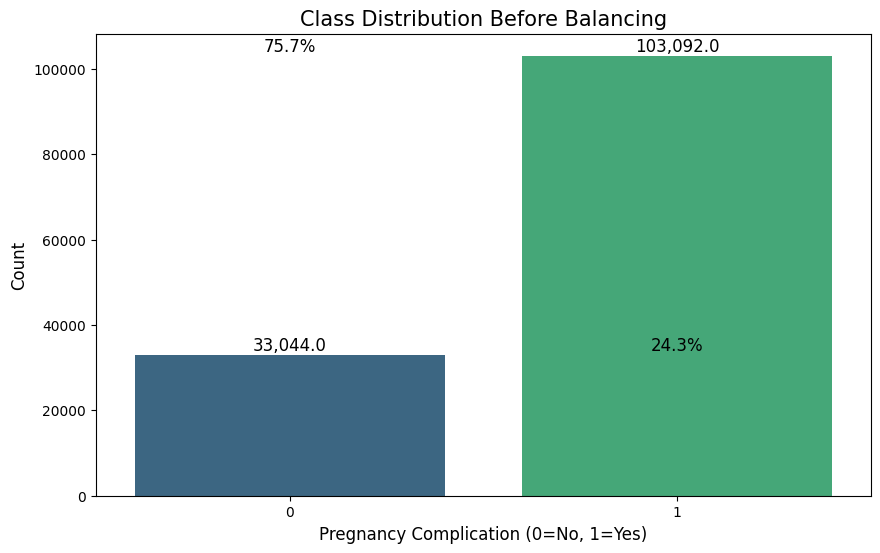


After cleaning:
Features shape: (136136, 93)
Number of features: 93

Missing values after imputation: 0
Features standardized successfully


In [ ]:
# Dataset
print("Loading and exploring dataset...")
df = pd.read_csv('/content/Final.csv')

print(f"\nDataset shape: {df.shape}")
print(f"Number of missing values: {df.isnull().sum().sum()}")

target_counts = df['Preg_Complication'].value_counts()
print(f"\nTarget variable distribution:\n{target_counts}")
print(f"Target variable percentage:\n{target_counts / len(df) * 100}")

plt.figure(figsize=(10, 6))
ax = sns.countplot(x='Preg_Complication', data=df, palette='viridis')
plt.title('Class Distribution Before Balancing', fontsize=15)
plt.xlabel('Pregnancy Complication (0=No, 1=Yes)', fontsize=12)
plt.ylabel('Count', fontsize=12)

for p in ax.patches:
    ax.annotate(f'{p.get_height():,}',
                (p.get_x() + p.get_width()/2., p.get_height()),
                ha='center', va='bottom', fontsize=12)

for i, count in enumerate(target_counts):
    percentage = count / len(df) * 100
    ax.text(i, count + 1000, f'{percentage:.1f}%', ha='center', fontsize=12)

plt.show()

df = df.dropna(axis=1, how='all').drop_duplicates()
df = df.select_dtypes(include=[np.number])

X = df.drop(columns=['Preg_Complication'], errors='ignore')
y = df['Preg_Complication']

print(f"\nAfter cleaning:")
print(f"Features shape: {X.shape}")
print(f"Number of features: {X.shape[1]}")


X = X.fillna(X.median())
print("\nMissing values after imputation:", X.isnull().sum().sum())

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print("Features standardized successfully")

# Step 3: Feature Selection with LASSO


PERFORMING LASSO FEATURE SELECTION
Training LASSO model with cross-validation...
Optimal alpha value: 0.001340

Number of features selected by LASSO: 67 out of 93

Top 20 most important features selected by LASSO:
1. Prenatal_care             0.1472
2. Preg_intParaDrug          0.0355
3. Resp_healthChk            0.0309
4. IronPill                  0.0161
5. Benefit_HCare             0.0160
6. PostnatalChk              0.0144
7. ultrasound                0.0112
8. HealthInsurance           0.0110
9. LastChild_Want            0.0107
10. DeliveryPlace_Private     -0.0105
11. Religion_Sikh             0.0101
12. Ethnicity_No caste / tribe 0.0098
13. VitaminA                  0.0095
14. DPT_full                  -0.0090
15. Antenatal_visits          0.0087
16. ChildGiven_otherBMilk     -0.0082
17. Alcohol                   0.0082
18. Water_Source_Other        -0.0082
19. ChildAge_mnths            0.0070
20. Preg_iron                 0.0067


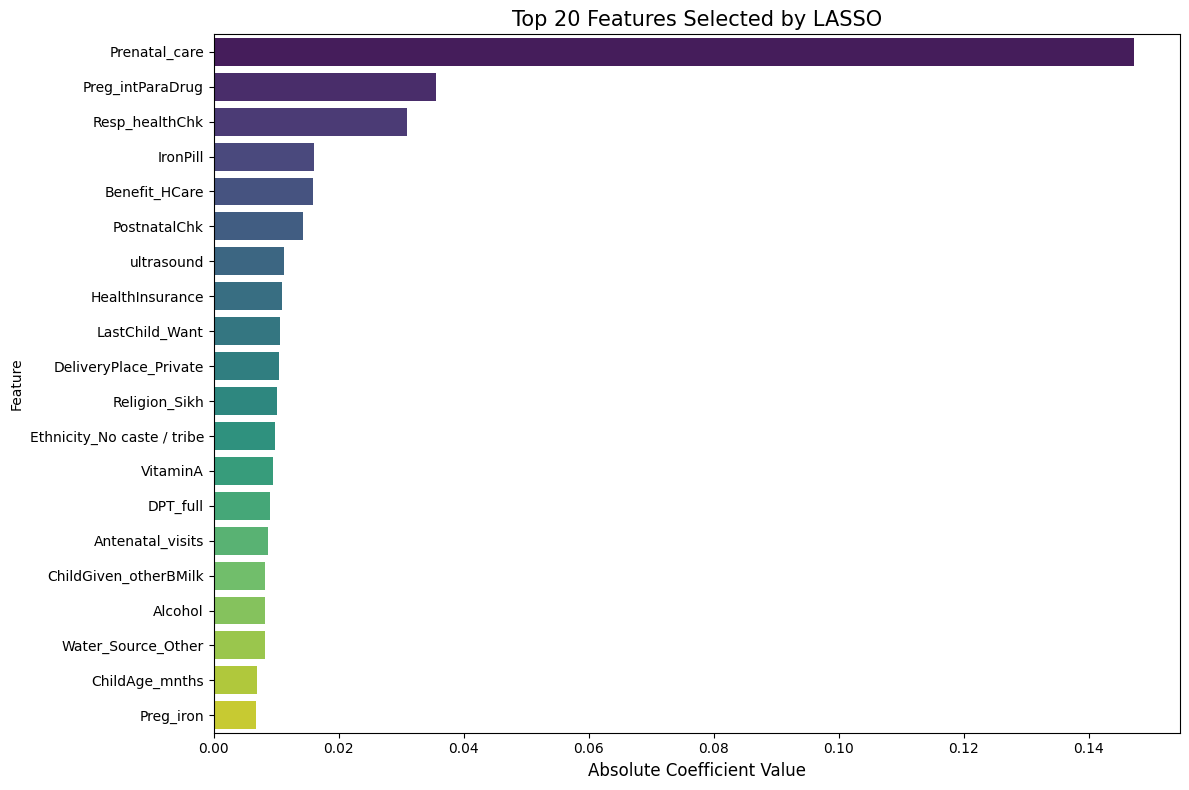


Selected features data shape: (136136, 67)
Selected feature names saved to 'results/feature_names.npy'


In [ ]:
# Feature Selection with LASSO
print("PERFORMING LASSO FEATURE SELECTION")

# Define LASSO model with cross-validation for optimal alpha
lasso_cv = LassoCV(cv=5, random_state=42, max_iter=10000)
print("Training LASSO model with cross-validation...")
lasso_cv.fit(X_scaled, y)

print(f"Optimal alpha value: {lasso_cv.alpha_:.6f}")

# Get non-zero coefficients (selected features)
selected_features_mask = lasso_cv.coef_ != 0
selected_features = np.where(selected_features_mask)[0]
selected_feature_names = X.columns[selected_features].tolist()

print(f"\nNumber of features selected by LASSO: {len(selected_features)} out of {X.shape[1]}")

feature_importance_df = pd.DataFrame({
    'Feature': X.columns[selected_features],
    'Coefficient': lasso_cv.coef_[selected_features]
})

# Sort by absolute coefficient value
feature_importance_df['AbsCoefficient'] = feature_importance_df['Coefficient'].abs()
feature_importance_df = feature_importance_df.sort_values('AbsCoefficient', ascending=False)

# Display top 20 features
print("\nTop 20 most important features selected by LASSO:")
for i, (feature, coef) in enumerate(zip(feature_importance_df['Feature'][:20],
                                        feature_importance_df['Coefficient'][:20])):
    print(f"{i+1}. {feature:<25} {coef:.4f}")

# Visualize feature importances
plt.figure(figsize=(12, 8))
top_features = feature_importance_df.head(20)
sns.barplot(x='AbsCoefficient', y='Feature', data=top_features, palette='viridis')
plt.title('Top 20 Features Selected by LASSO', fontsize=15)
plt.xlabel('Absolute Coefficient Value', fontsize=12)
plt.tight_layout()
plt.show()

X_selected = X_scaled[:, selected_features]
print(f"\nSelected features data shape: {X_selected.shape}")

# Save selected feature names
np.save('results/feature_names.npy', selected_feature_names)
print("Selected feature names saved to 'results/feature_names.npy'")

# Step 4: Handling Class Imbalance with SMOTETomek


HANDLING CLASS IMBALANCE WITH NEARSMOTE
Class distribution before balancing:
Preg_Complication
1    103092
0     33044
Name: count, dtype: int64
Class ratio before balancing: 1:0.32


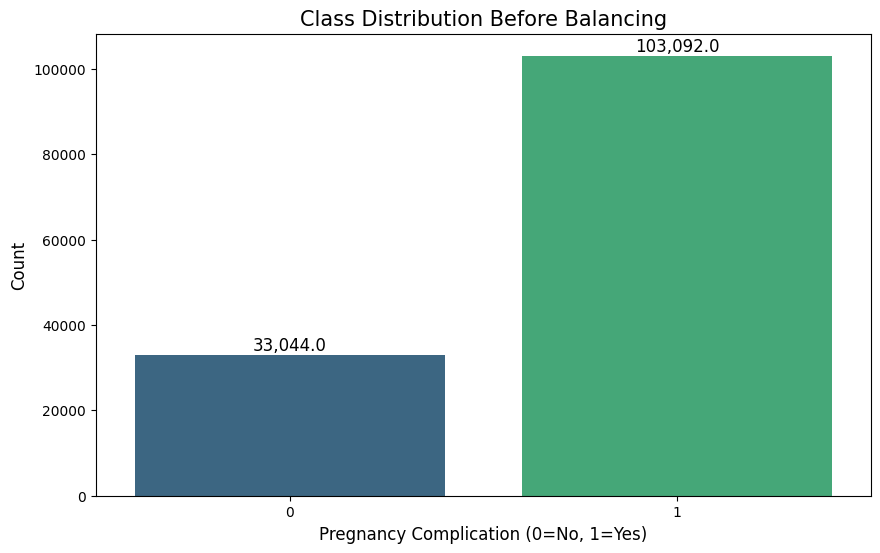


Implementing NearSMOTE (SMOTE + NearMiss + SMOTETomek)...

Class distribution after balancing:
Preg_Complication
0    102691
1    102691
Name: count, dtype: int64
Class ratio after balancing: 1:1.00


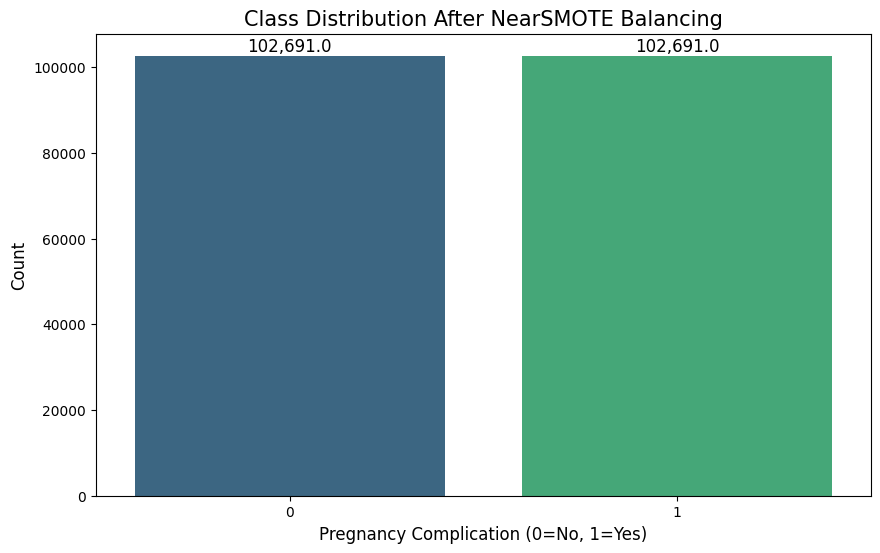


Data shape after balancing: (205382, 67)

Memory cleaned up successfully


In [ ]:
# Class Imbalance with NearSMOTE (SMOTE + NearMiss + SMOTETomek)
print("HANDLING CLASS IMBALANCE WITH NEARSMOTE")

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.combine import SMOTETomek
from imblearn.pipeline import Pipeline

print("Class distribution before balancing:")
print(pd.Series(y).value_counts())
print(f"Class ratio before balancing: 1:{pd.Series(y).value_counts()[0]/pd.Series(y).value_counts()[1]:.2f}")

plt.figure(figsize=(10, 6))
ax = sns.countplot(x=y, palette='viridis')
plt.title('Class Distribution Before Balancing', fontsize=15)
plt.xlabel('Pregnancy Complication (0=No, 1=Yes)', fontsize=12)
plt.ylabel('Count', fontsize=12)

for p in ax.patches:
    ax.annotate(f'{p.get_height():,}',
                (p.get_x() + p.get_width()/2., p.get_height()),
                ha='center', va='bottom', fontsize=12)

plt.show()

# Define NearSMOTE pipeline
print("\nImplementing NearSMOTE (SMOTE + NearMiss + SMOTETomek)...")
nearsmote = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('nearmiss', NearMiss(version=1, n_neighbors=3)),
    ('smotetomek', SMOTETomek(random_state=42))
])

# Apply NearSMOTE
X_balanced, y_balanced = nearsmote.fit_resample(X_selected, y)

# Display class distribution after balancing
print("\nClass distribution after balancing:")
balanced_counts = pd.Series(y_balanced).value_counts()
print(balanced_counts)
print(f"Class ratio after balancing: 1:{balanced_counts[0]/balanced_counts[1]:.2f}")

# Visualize balanced class distribution
plt.figure(figsize=(10, 6))
ax = sns.countplot(x=y_balanced, palette='viridis')
plt.title('Class Distribution After NearSMOTE Balancing', fontsize=15)
plt.xlabel('Pregnancy Complication (0=No, 1=Yes)', fontsize=12)
plt.ylabel('Count', fontsize=12)

for p in ax.patches:
    ax.annotate(f'{p.get_height():,}',
                (p.get_x() + p.get_width()/2., p.get_height()),
                ha='center', va='bottom', fontsize=12)

plt.show()

print(f"\nData shape after balancing: {X_balanced.shape}")

gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()
print("\nMemory cleaned up successfully")

# Step 5: Cross-Validation Setup

In [ ]:
# Cross-Validation Setup
print("CROSS-VALIDATION SETUP WITH DATA TYPE ANALYSIS")

# Define the number of folds for cross-validation
n_folds = 10
kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)

print(f"Setting up {n_folds}-fold cross-validation")

# Split the balanced data for the initial evaluation
X_train, X_test, y_train, y_test = train_test_split(
    X_balanced, y_balanced, test_size=0.2, random_state=42, stratify=y_balanced
)

print(f"Initial train-test split shapes:")
print(f"X_train: {X_train.shape}, y_train: {len(y_train)}")
print(f"X_test: {X_test.shape}, y_test: {len(y_test)}")

# Convert labels to the correct data type for PyTorch
y_train_f = y_train.astype(np.float32)
y_test_f = y_test.astype(np.float32)

# For our tabular models, we'll treat features with few unique values as categorical
# and features with many unique values as numerical
print("\nAnalyzing feature characteristics to determine categorical vs numerical...")

# Function to identify categorical features based on number of unique values
def identify_categorical_features(X, feature_names, threshold=10):
    """
    Identify categorical features based on the number of unique values.
    If a feature has <= threshold unique values, it's likely categorical.
    """
    cat_indices = []
    cat_names = []
    num_indices = []
    num_names = []

    for i, name in enumerate(feature_names):
        # Count unique values
        unique_vals = np.unique(X[:, i])
        n_unique = len(unique_vals)

        if n_unique <= threshold and np.issubdtype(unique_vals.dtype, np.integer):
            cat_indices.append(i)
            cat_names.append(name)
        else:
            num_indices.append(i)
            num_names.append(name)

    return cat_indices, cat_names, num_indices, num_names

# Identify categorical and numerical features
cat_cols, cat_feature_names, num_cols, num_feature_names = identify_categorical_features(
    X_train, selected_feature_names, threshold=15
)

print(f"\nIdentified {len(cat_cols)} categorical features and {len(num_cols)} numerical features among selected features")
print(f"Categorical features ({len(cat_feature_names)}):")
for i, feat in enumerate(cat_feature_names):
    unique_count = len(np.unique(X_train[:, cat_cols[i]]))
    print(f"  {i+1}. {feat:<30} (Unique values: {unique_count})")

print(f"\nNumerical features ({len(num_feature_names)}):")
for i, feat in enumerate(num_feature_names[:5]):
    if i < 5:  # Print only first 5 numerical features
        unique_count = len(np.unique(X_train[:, num_cols[i]]))
        print(f"  {i+1}. {feat:<30} (Unique values: {unique_count})")
if len(num_feature_names) > 5:
    print(f"  ... and {len(num_feature_names)-5} more numerical features")

# Function to split data into categorical and numerical arrays
def split_cat_num(X):
    if len(cat_cols) > 0:
        X_cat = X[:, cat_cols].astype(np.int64)  # Ensure categorical features are integers
    else:
        X_cat = np.zeros((X.shape[0], 1), dtype=np.int64) 

    if len(num_cols) > 0:
        X_num = X[:, num_cols].astype(np.float32)  # numerical features
    else:
        X_num = np.zeros((X.shape[0], 1), dtype=np.float32) 

    return X_cat, X_num

# Get categorical and numerical parts
X_train_cat, X_train_num = split_cat_num(X_train)
X_test_cat, X_test_num = split_cat_num(X_test)

# For TabNet: combine both into a single array
X_train_tabnet = np.concatenate([X_train_cat, X_train_num], axis=1)
X_test_tabnet = np.concatenate([X_test_cat, X_test_num], axis=1)

# Get cardinalities for categorical features
def get_cat_cardinalities(X_cat):
    cardinals = []
    for col_idx in range(X_cat.shape[1]):
        unique_vals = np.unique(X_cat[:, col_idx])
        cardinals.append(len(unique_vals))
    return tuple(cardinals)

# Get cardinalities for categorical features
cat_cardinalities = get_cat_cardinalities(X_train_cat)
print(f"\nCategorical feature cardinalities: {cat_cardinalities}")

# Save processed data for later use
np.save('results/X_train.npy', X_train)
np.save('results/X_test.npy', X_test)
np.save('results/y_train.npy', y_train)
np.save('results/y_test.npy', y_test)
print("\nProcessed data saved to 'results/' folder")

# Clean up memory
gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()
print("\nMemory cleaned up successfully")


CROSS-VALIDATION SETUP WITH DATA TYPE ANALYSIS
Setting up 10-fold cross-validation
Initial train-test split shapes:
X_train: (164305, 67), y_train: 164305
X_test: (41077, 67), y_test: 41077

Analyzing feature characteristics to determine categorical vs numerical...

Identified 0 categorical features and 67 numerical features among selected features
Categorical features (0):

Numerical features (67):
  1. Water_Source_Time              (Unique values: 18344)
  2. Toilet_Facility                (Unique values: 6384)
  3. House_electricity              (Unique values: 271)
  4. House_radio                    (Unique values: 950)
  5. House_bicycle                  (Unique values: 13355)
  ... and 62 more numerical features

Categorical feature cardinalities: (1,)

Processed data saved to 'results/' folder

Memory cleaned up successfully


# Step 6: Model Definition (TabTransformer, FT-Transformer, TabNet)

In [ ]:
# Model Definition
print("MODEL DEFINITION")
# 1. TabTransformer Model
model_tab = TabTransformer(
    categories=cat_cardinalities,  
    num_continuous=X_train_num.shape[1],  
    dim=64,           
    dim_out=1,        
    depth=4,         
    heads=4,          
    attn_dropout=0.1, 
    ff_dropout=0.1    
).to(device)

print("TabTransformer model defined")
print(f"- Categorical features: {len(cat_cardinalities)}")
print(f"- Numerical features: {X_train_num.shape[1]}")
print(f"- Transformer depth: 4, heads: 4")

# 2. FT-Transformer Model
model_ft = FTTransformer(
    categories=cat_cardinalities,
    num_continuous=X_train_num.shape[1],
    dim=32,           
    dim_out=1,       
    depth=2,          
    heads=2,          
    attn_dropout=0.2, 
    ff_dropout=0.2  
).to(device)

print("\nFT-Transformer model defined")
print(f"- Categorical features: {len(cat_cardinalities)}")
print(f"- Numerical features: {X_train_num.shape[1]}")
print(f"- Transformer depth: 2, heads: 2")

# 3. TabNet Model
# Initialize TabNet model
model_tabnet = TabNetClassifier(
    n_d=16,           
    n_a=16,           
    n_steps=4,        
    gamma=1.3,        
    cat_idxs=[],      
    cat_dims=[],      
    cat_emb_dim=1,    
    optimizer_fn=torch.optim.Adam,  
    optimizer_params=dict(lr=1e-3), 
    scheduler_params={"step_size":10, "gamma":0.9},  
    scheduler_fn=torch.optim.lr_scheduler.StepLR,
    mask_type='sparsemax'  
)

print("\nTabNet model defined")
print(f"- Decision layer width: 16")
print(f"- Attention embedding width: 16")
print(f"- Number of steps: 4")

# FIXED: TabTransformer and FT-Transformer
def train_tabular_model(model, X_cat, X_num, y, X_cat_val, X_num_val, y_val,
                        epochs=15, batch_size=256, lr=1e-3):
    """
    Train a tabular transformer model (TabTransformer or FT-Transformer).
    """
    # Convert pandas Series to numpy array 
    if hasattr(y, 'values'):
        y = y.values
    if hasattr(y_val, 'values'):
        y_val = y_val.values

    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    dataset = TensorDataset(
        torch.tensor(X_cat, dtype=torch.long),
        torch.tensor(X_num, dtype=torch.float32),
        torch.tensor(y, dtype=torch.float32).view(-1, 1)
    )
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    X_cat_val_t = torch.tensor(X_cat_val, dtype=torch.long).to(device)
    X_num_val_t = torch.tensor(X_num_val, dtype=torch.float32).to(device)
    y_val_t = torch.tensor(y_val, dtype=torch.float32).view(-1, 1).to(device)

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    for epoch in range(epochs):
        model.train()
        total_loss = 0.0
        total_correct, total_samples = 0, 0

        for cat_b, num_b, y_b in loader:
            cat_b = cat_b.to(device)
            num_b = num_b.to(device)
            y_b = y_b.to(device)

            optimizer.zero_grad()
            logits = model(cat_b, num_b)
            loss = criterion(logits, y_b)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            preds = (torch.sigmoid(logits) > 0.5).float()
            total_correct += (preds == y_b).sum().item()
            total_samples += y_b.size(0)

        avg_loss = total_loss / len(loader)
        train_acc = total_correct / total_samples

        # Validation phase
        model.eval()
        with torch.no_grad():
            val_logits = model(X_cat_val_t, X_num_val_t)
            val_loss = criterion(val_logits, y_val_t).item()
            val_preds = (torch.sigmoid(val_logits) > 0.5).float()
            val_correct = (val_preds == y_val_t).sum().item()
            val_acc = val_correct / y_val_t.size(0)

        train_losses.append(avg_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    return train_losses, val_losses, train_accs, val_accs

# TabNet 
def train_tabnet(model_tabnet, X_train, y_train, X_valid, y_valid, max_epochs=20, batch_size=1024):
    """
    Train a TabNet model with proper formatting for inputs and using built-in accuracy.
    """
    # Convert pandas Series to numpy array
    if hasattr(y_train, 'values'):
        y_train = y_train.values
    if hasattr(y_valid, 'values'):
        y_valid = y_valid.values

    # Ensure data types are correct for TabNet
    X_train = X_train.astype(np.float32)
    X_valid = X_valid.astype(np.float32)

    # Make sure targets are integers
    y_train = y_train.astype(np.int64)
    y_valid = y_valid.astype(np.int64)

    print(f"Training TabNet with data shape: {X_train.shape}, target shape: {y_train.shape}")

    
    history = model_tabnet.fit(
        X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        eval_name=['val'],
        eval_metric=['accuracy'],  # Using built-in accuracy metric
        max_epochs=max_epochs,
        patience=5,
        batch_size=batch_size,
        virtual_batch_size=128,
        num_workers=0  # This is to avoid multiprocessing issues
    )
    return history

print("\nTraining functions defined")

gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()
print("\nMemory cleaned up successfully")


MODEL DEFINITION
TabTransformer model defined
- Categorical features: 1
- Numerical features: 67
- Transformer depth: 4, heads: 4

FT-Transformer model defined
- Categorical features: 1
- Numerical features: 67
- Transformer depth: 2, heads: 2

TabNet model defined
- Decision layer width: 16
- Attention embedding width: 16
- Number of steps: 4

Training functions defined

Memory cleaned up successfully


# Step 7: Cross-Validation Training of Models


CROSS-VALIDATION TRAINING
Performing 10-fold cross-validation...

-------------------- Fold 1/10 --------------------
Initializing models for this fold...

Training TabTransformer...
Epoch 1/10, Train Loss: 0.5861, Train Acc: 0.6637, Val Loss: 0.5656, Val Acc: 0.6828
Epoch 2/10, Train Loss: 0.5536, Train Acc: 0.6945, Val Loss: 0.5485, Val Acc: 0.6997
Epoch 3/10, Train Loss: 0.5287, Train Acc: 0.7204, Val Loss: 0.5257, Val Acc: 0.7236
Epoch 4/10, Train Loss: 0.4952, Train Acc: 0.7477, Val Loss: 0.5030, Val Acc: 0.7465
Epoch 5/10, Train Loss: 0.4540, Train Acc: 0.7777, Val Loss: 0.4714, Val Acc: 0.7700
Epoch 6/10, Train Loss: 0.4098, Train Acc: 0.8069, Val Loss: 0.4454, Val Acc: 0.7836
Epoch 7/10, Train Loss: 0.3673, Train Acc: 0.8324, Val Loss: 0.4344, Val Acc: 0.7953
Epoch 8/10, Train Loss: 0.3308, Train Acc: 0.8527, Val Loss: 0.4116, Val Acc: 0.8105
Epoch 9/10, Train Loss: 0.2964, Train Acc: 0.8714, Val Loss: 0.4057, Val Acc: 0.8189
Epoch 10/10, Train Loss: 0.2665, Train Acc: 0.8870,

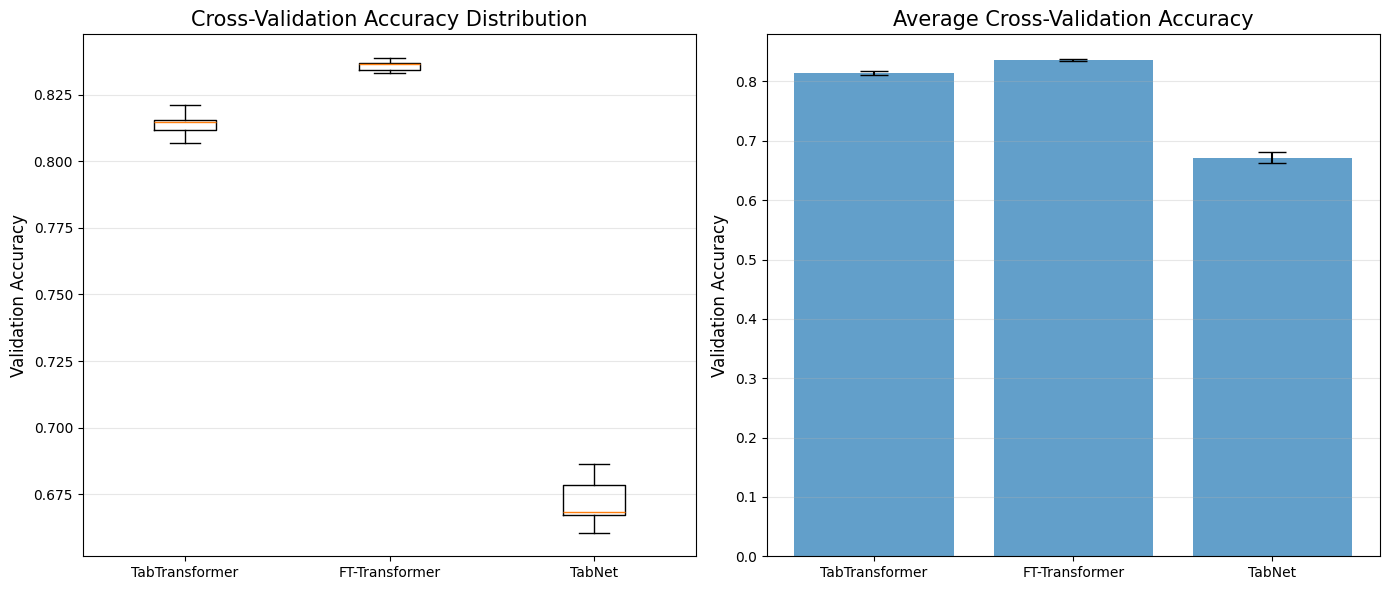


Memory cleaned up successfully


In [ ]:
# Cross-Validation Training
print("CROSS-VALIDATION TRAINING")

# Initialize lists to store cross-validation results
cv_results = {
    'tabtransformer': {
        'train_acc': [], 'val_acc': [],
        'train_loss': [], 'val_loss': [],
        'fold_preds': []
    },
    'fttransformer': {
        'train_acc': [], 'val_acc': [],
        'train_loss': [], 'val_loss': [],
        'fold_preds': []
    },
    'tabnet': {
        'val_acc': [],
        'fold_preds': []
    }
}

# Convert y_balanced to numpy array
if hasattr(y_balanced, 'values'):
    y_balanced = y_balanced.values

# Define prediction functions
def predict_tabtransformer(model, X_cat, X_num):
    model.eval()
    with torch.no_grad():
        cat_t = torch.tensor(X_cat, dtype=torch.long).to(device)
        num_t = torch.tensor(X_num, dtype=torch.float32).to(device)
        logits = model(cat_t, num_t).squeeze(1)
        probs = torch.sigmoid(logits).cpu().numpy()
    return probs

# FT-Transformer
predict_fttransformer = predict_tabtransformer

# TabNet
def predict_tabnet(model_tabnet, X):
    # Ensure X is float32
    X = X.astype(np.float32)
    probs = model_tabnet.predict_proba(X)[:, 1]
    return probs

# No of Folds
n_folds = 10

# Perform cross-validation
print(f"Performing {n_folds}-fold cross-validation...")

fold = 1
for train_idx, val_idx in kf.split(X_balanced):
    print(f"\n{'-'*20} Fold {fold}/{n_folds} {'-'*20}")

    # Split data for this fold
    X_train_fold, X_val_fold = X_balanced[train_idx], X_balanced[val_idx]
    y_train_fold, y_val_fold = y_balanced[train_idx], y_balanced[val_idx]

    
    y_train_fold_f = y_train_fold.astype(np.float32)
    y_val_fold_f = y_val_fold.astype(np.float32)

    # Split categorical and numerical features
    X_train_cat_fold, X_train_num_fold = split_cat_num(X_train_fold)
    X_val_cat_fold, X_val_num_fold = split_cat_num(X_val_fold)

    # For TabNet: combine both into a single array and convert to float32
    X_train_tabnet_fold = np.concatenate([X_train_cat_fold, X_train_num_fold], axis=1).astype(np.float32)
    X_val_tabnet_fold = np.concatenate([X_val_cat_fold, X_val_num_fold], axis=1).astype(np.float32)

    # Initialize models for this fold
    print("Initializing models for this fold...")

    # TabTransformer
    model_tab_fold = TabTransformer(
        categories=cat_cardinalities,
        num_continuous=X_train_num_fold.shape[1],
        dim=64, dim_out=1, depth=4, heads=4,
        attn_dropout=0.1, ff_dropout=0.1
    ).to(device)

    # FT-Transformer
    model_ft_fold = FTTransformer(
        categories=cat_cardinalities,
        num_continuous=X_train_num_fold.shape[1],
        dim=32, dim_out=1, depth=2, heads=2,
        attn_dropout=0.2, ff_dropout=0.2
    ).to(device)

    # TabNet
    model_tabnet_fold = TabNetClassifier(
        n_d=16, n_a=16, n_steps=4, gamma=1.3,
        cat_idxs=[], cat_dims=[], cat_emb_dim=1,
        optimizer_fn=torch.optim.Adam,
        optimizer_params=dict(lr=1e-3),
        scheduler_params={"step_size":10, "gamma":0.9},
        scheduler_fn=torch.optim.lr_scheduler.StepLR,
        mask_type='sparsemax'
    )

    # Train TabTransformer
    print("\nTraining TabTransformer...")
    tab_train_loss, tab_val_loss, tab_train_acc, tab_val_acc = train_tabular_model(
        model_tab_fold,
        X_train_cat_fold, X_train_num_fold, y_train_fold_f,
        X_val_cat_fold, X_val_num_fold, y_val_fold_f,
        epochs=10, batch_size=256, lr=1e-3
    )

    # Store results
    cv_results['tabtransformer']['train_acc'].append(tab_train_acc[-1])
    cv_results['tabtransformer']['val_acc'].append(tab_val_acc[-1])
    cv_results['tabtransformer']['train_loss'].append(tab_train_loss[-1])
    cv_results['tabtransformer']['val_loss'].append(tab_val_loss[-1])

    # Get predictions for validation set
    tab_preds = predict_tabtransformer(model_tab_fold, X_val_cat_fold, X_val_num_fold)
    cv_results['tabtransformer']['fold_preds'].append((y_val_fold, tab_preds))

    
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    # Train FT-Transformer
    print("\nTraining FT-Transformer...")
    ft_train_loss, ft_val_loss, ft_train_acc, ft_val_acc = train_tabular_model(
        model_ft_fold,
        X_train_cat_fold, X_train_num_fold, y_train_fold_f,
        X_val_cat_fold, X_val_num_fold, y_val_fold_f,
        epochs=15, batch_size=256, lr=1e-3
    )

    # Store results
    cv_results['fttransformer']['train_acc'].append(ft_train_acc[-1])
    cv_results['fttransformer']['val_acc'].append(ft_val_acc[-1])
    cv_results['fttransformer']['train_loss'].append(ft_train_loss[-1])
    cv_results['fttransformer']['val_loss'].append(ft_val_loss[-1])

    ft_preds = predict_fttransformer(model_ft_fold, X_val_cat_fold, X_val_num_fold)
    cv_results['fttransformer']['fold_preds'].append((y_val_fold, ft_preds))

    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    # Train TabNet
    print("\nTraining TabNet...")
    try:
        # Convert targets to integers for TabNet
        y_train_fold_int = y_train_fold.astype(np.int64)
        y_val_fold_int = y_val_fold.astype(np.int64)

        # Start TabNet training with the updated function
        history = model_tabnet_fold.fit(
            X_train_tabnet_fold, y_train_fold_int,
            eval_set=[(X_val_tabnet_fold, y_val_fold_int)],
            eval_name=['val'],
            eval_metric=['accuracy'],  # Use built-in accuracy metric
            max_epochs=10,
            patience=5,
            batch_size=1024,
            virtual_batch_size=128,
            num_workers=0  # Avoid multiprocessing issues
        )

        # Evaluate TabNet on validation set
        y_pred_proba = model_tabnet_fold.predict_proba(X_val_tabnet_fold)[:, 1]
        y_pred = (y_pred_proba > 0.5).astype(int)
        val_acc = accuracy_score(y_val_fold, y_pred)

        # Store results
        cv_results['tabnet']['val_acc'].append(val_acc)
        cv_results['tabnet']['fold_preds'].append((y_val_fold, y_pred_proba))

        print(f"TabNet        - Val Acc: {val_acc:.4f}")
    except Exception as e:
        print(f"Error training TabNet: {e}")
        traceback_str = traceback.format_exc()
        print(f"Traceback: {traceback_str}")
        # Store placeholder results if TabNet fails
        cv_results['tabnet']['val_acc'].append(0.0)
        cv_results['tabnet']['fold_preds'].append((y_val_fold, np.zeros_like(y_val_fold)))

    print(f"\nFold {fold} results:")
    print(f"TabTransformer - Val Acc: {tab_val_acc[-1]:.4f}, Val Loss: {tab_val_loss[-1]:.4f}")
    print(f"FT-Transformer - Val Acc: {ft_val_acc[-1]:.4f}, Val Loss: {ft_val_loss[-1]:.4f}")

    # Clean up memory
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    fold += 1

# Calculate average cross-validation performance
print("\nAverage Cross-Validation Performance:")
print(f"TabTransformer - Val Acc: {np.mean(cv_results['tabtransformer']['val_acc']):.4f} ± {np.std(cv_results['tabtransformer']['val_acc']):.4f}")
print(f"FT-Transformer - Val Acc: {np.mean(cv_results['fttransformer']['val_acc']):.4f} ± {np.std(cv_results['fttransformer']['val_acc']):.4f}")

# Only calculate TabNet stats if there are valid results
tabnet_accs = [acc for acc in cv_results['tabnet']['val_acc'] if acc > 0]
if tabnet_accs:
    print(f"TabNet        - Val Acc: {np.mean(tabnet_accs):.4f} ± {np.std(tabnet_accs):.4f}")
else:
    print("TabNet        - No valid results available")

# Visualize cross-validation performance
plt.figure(figsize=(14, 6))
models = ['TabTransformer', 'FT-Transformer']
val_accs = [
    cv_results['tabtransformer']['val_acc'],
    cv_results['fttransformer']['val_acc'],
]

if tabnet_accs:
    models.append('TabNet')
    val_accs.append(tabnet_accs)

# Box plot of validation accuracies
plt.subplot(1, 2, 1)
plt.boxplot(val_accs, labels=models)
plt.title('Cross-Validation Accuracy Distribution', fontsize=15)
plt.ylabel('Validation Accuracy', fontsize=12)
plt.grid(axis='y', alpha=0.3)

# Bar plot of average validation accuracies
plt.subplot(1, 2, 2)
avg_accs = [np.mean(acc) for acc in val_accs]
std_accs = [np.std(acc) for acc in val_accs]
plt.bar(models, avg_accs, yerr=std_accs, capsize=10, alpha=0.7)
plt.title('Average Cross-Validation Accuracy', fontsize=15)
plt.ylabel('Validation Accuracy', fontsize=12)
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Clean up memory
gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()
print("\nMemory cleaned up successfully")

# Step 8: Ensemble Creation


ENSEMBLE MODEL CREATION AND FINAL EVALUATION
Training final models on the full training set...

Training final TabTransformer model...
Epoch 1/15, Train Loss: 0.5875, Train Acc: 0.6616, Val Loss: 0.5673, Val Acc: 0.6806
Epoch 2/15, Train Loss: 0.5575, Train Acc: 0.6918, Val Loss: 0.5507, Val Acc: 0.6964
Epoch 3/15, Train Loss: 0.5344, Train Acc: 0.7156, Val Loss: 0.5312, Val Acc: 0.7170
Epoch 4/15, Train Loss: 0.5057, Train Acc: 0.7402, Val Loss: 0.5195, Val Acc: 0.7325
Epoch 5/15, Train Loss: 0.4689, Train Acc: 0.7670, Val Loss: 0.4877, Val Acc: 0.7536
Epoch 6/15, Train Loss: 0.4288, Train Acc: 0.7943, Val Loss: 0.4656, Val Acc: 0.7723
Epoch 7/15, Train Loss: 0.3869, Train Acc: 0.8211, Val Loss: 0.4455, Val Acc: 0.7866
Epoch 8/15, Train Loss: 0.3480, Train Acc: 0.8433, Val Loss: 0.4400, Val Acc: 0.7951
Epoch 9/15, Train Loss: 0.3124, Train Acc: 0.8639, Val Loss: 0.4333, Val Acc: 0.8034
Epoch 10/15, Train Loss: 0.2795, Train Acc: 0.8807, Val Loss: 0.4534, Val Acc: 0.7991
Epoch 11/15, 

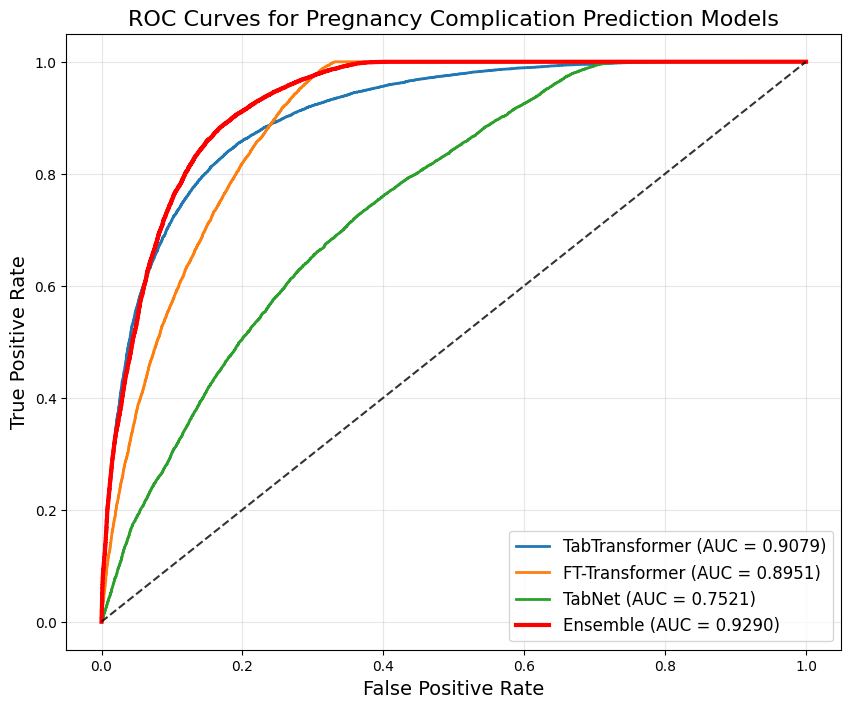


Visualization of top features from LASSO selection:


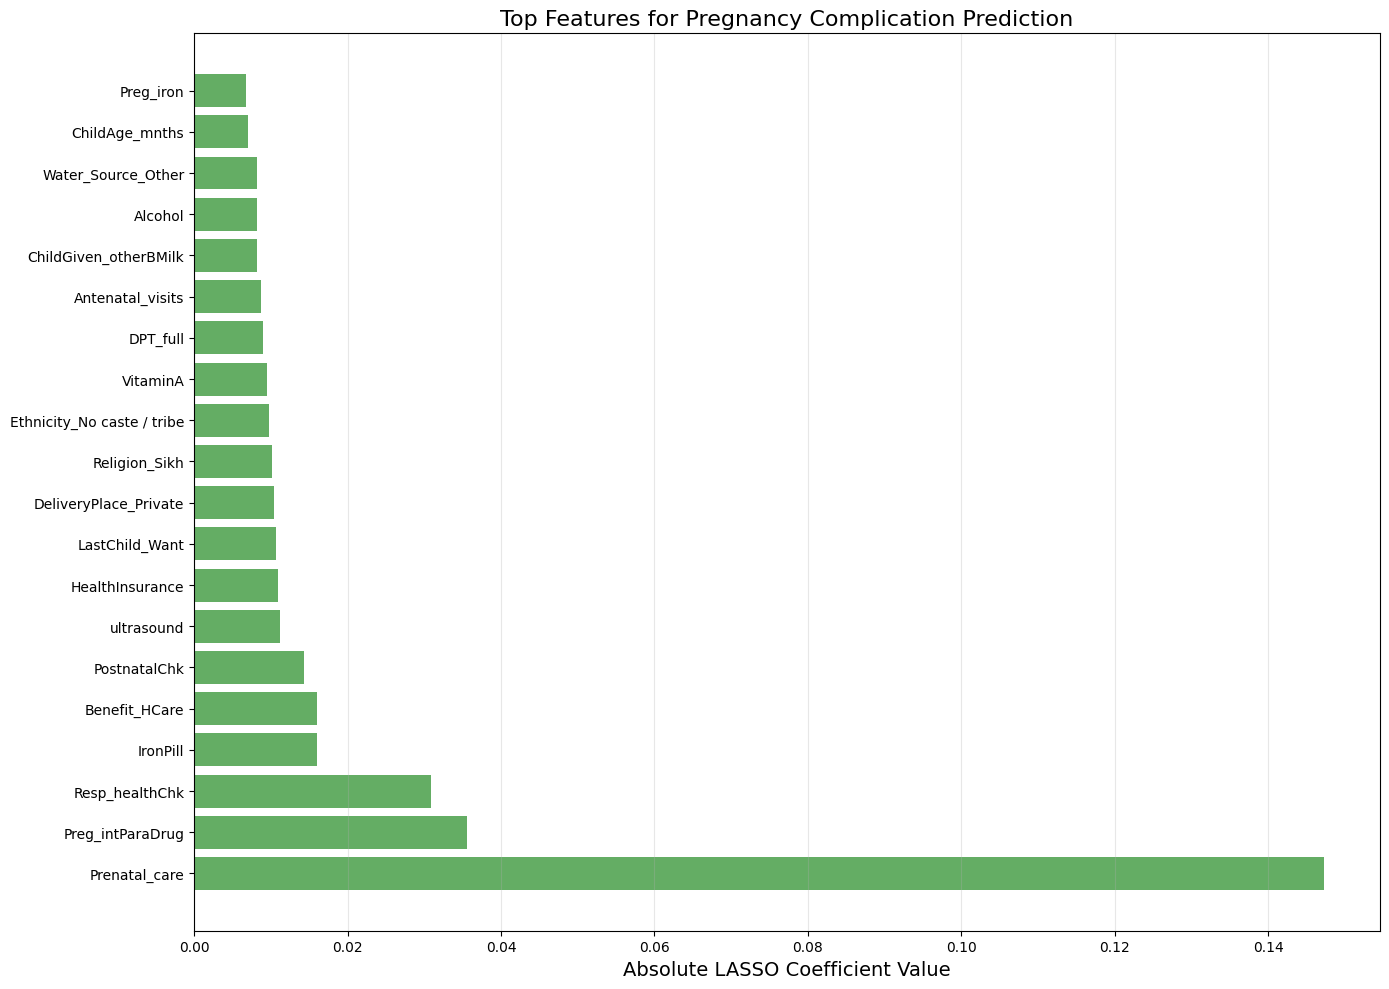

NameError: name 'confusion_matrix' is not defined

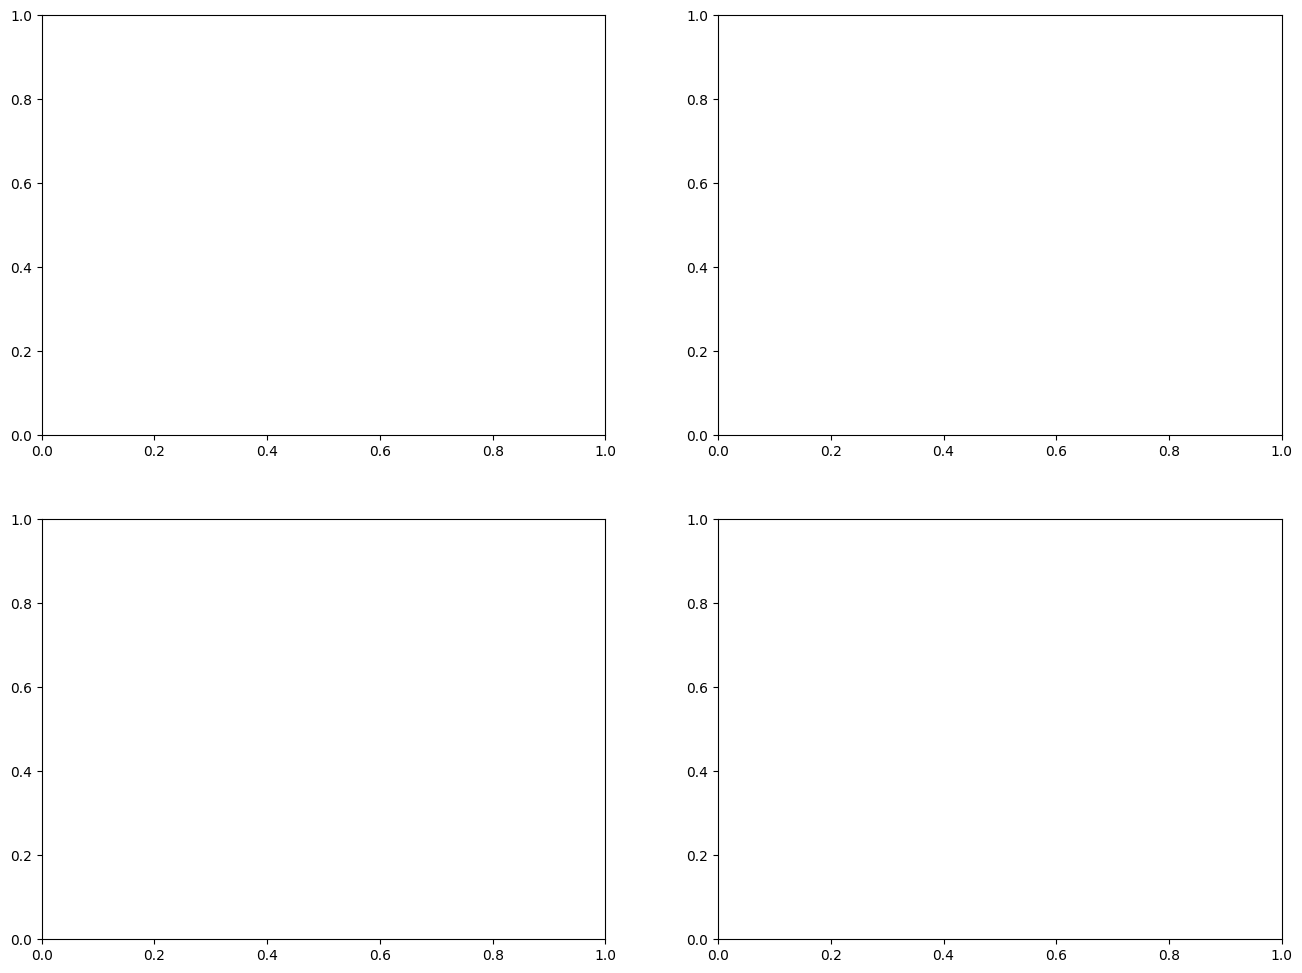

In [ ]:
# Ensemble Model Creation and Final Evaluation
print("ENSEMBLE MODEL CREATION AND FINAL EVALUATION")

print("Training final models on the full training set...")

# 1. TabTransformer
print("\nTraining final TabTransformer model...")
tab_train_loss, tab_val_loss, tab_train_acc, tab_val_acc = train_tabular_model(
    model_tab,
    X_train_cat, X_train_num, y_train_f,
    X_test_cat, X_test_num, y_test_f,
    epochs=15, batch_size=256, lr=1e-3
)

# 2. FT-Transformer
print("\nTraining final FT-Transformer model...")
ft_train_loss, ft_val_loss, ft_train_acc, ft_val_acc = train_tabular_model(
    model_ft,
    X_train_cat, X_train_num, y_train_f,
    X_test_cat, X_test_num, y_test_f,
    epochs=20, batch_size=256, lr=1e-3
)

# 3. TabNet
print("\nTraining final TabNet model...")
tabnet_trained = False
try:
    # Convert test data
    X_test_tabnet = np.concatenate([X_test_cat, X_test_num], axis=1).astype(np.float32)

    y_train_int = y_train.astype(np.int64)
    y_test_int = y_test.astype(np.int64)

    # Train TabNet
    model_tabnet.fit(
        X_train_tabnet.astype(np.float32), y_train_int,
        eval_set=[(X_test_tabnet, y_test_int)],
        eval_name=['val'],
        eval_metric=['accuracy'],
        max_epochs=15,
        patience=5,
        batch_size=1024,
        virtual_batch_size=128,
        num_workers=0
    )
    tabnet_trained = True
except Exception as e:
    print(f"Error training TabNet: {e}")
    import traceback
    traceback.print_exc()
    tabnet_trained = False

print("\nGenerating predictions from all models...")

# TabTransformer predictions
tab_preds = predict_tabtransformer(model_tab, X_test_cat, X_test_num)
tab_binary_preds = (tab_preds > 0.5).astype(int)

# FT-Transformer predictions
ft_preds = predict_fttransformer(model_ft, X_test_cat, X_test_num)
ft_binary_preds = (ft_preds > 0.5).astype(int)

# TabNet predictions
if tabnet_trained:
    tn_preds = model_tabnet.predict_proba(X_test_tabnet.astype(np.float32))[:, 1]
    tn_binary_preds = (tn_preds > 0.5).astype(int)
    print("TabNet training successful, using its predictions in ensemble")
else:
    print("Using average of TabTransformer and FT-Transformer for TabNet predictions")
    tn_preds = (tab_preds + ft_preds) / 2
    tn_binary_preds = (tn_preds > 0.5).astype(int)

ensemble_probs = (tab_preds + ft_preds + tn_preds) / 3
ensemble_preds = (ensemble_probs > 0.5).astype(int)

# Evaluate individual models and ensemble
print("\nModel Evaluation Results:")
print("-" * 80)
print(f"{'Model':<15} {'Accuracy':<10} {'Precision':<10} {'Recall':<10} {'F1 Score':<10} {'ROC-AUC':<10}")
print("-" * 80)

# Helper function for evaluation
def evaluate_model(y_true, y_pred, y_proba, model_name):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_proba)
    print(f"{model_name:<15} {acc:.4f}      {prec:.4f}      {rec:.4f}      {f1:.4f}      {auc:.4f}")
    return acc, prec, rec, f1, auc

# Evaluate All Models
tab_metrics = evaluate_model(y_test, tab_binary_preds, tab_preds, "TabTransformer")

ft_metrics = evaluate_model(y_test, ft_binary_preds, ft_preds, "FT-Transformer")

tn_metrics = evaluate_model(y_test, tn_binary_preds, tn_preds, "TabNet")

ensemble_metrics = evaluate_model(y_test, ensemble_preds, ensemble_probs, "Ensemble")
print("-" * 80)

# Plot ROC curves
plt.figure(figsize=(10, 8))
# ROC for TabTransformer
fpr_tab, tpr_tab, _ = roc_curve(y_test, tab_preds)
plt.plot(fpr_tab, tpr_tab, label=f'TabTransformer (AUC = {tab_metrics[4]:.4f})', linewidth=2)

# ROC for FT-Transformer
fpr_ft, tpr_ft, _ = roc_curve(y_test, ft_preds)
plt.plot(fpr_ft, tpr_ft, label=f'FT-Transformer (AUC = {ft_metrics[4]:.4f})', linewidth=2)

# ROC for TabNet
fpr_tn, tpr_tn, _ = roc_curve(y_test, tn_preds)
plt.plot(fpr_tn, tpr_tn, label=f'TabNet (AUC = {tn_metrics[4]:.4f})', linewidth=2)

# ROC for Ensemble
fpr_ens, tpr_ens, _ = roc_curve(y_test, ensemble_probs)
plt.plot(fpr_ens, tpr_ens, label=f'Ensemble (AUC = {ensemble_metrics[4]:.4f})', linewidth=3, color='red')

# Reference line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', alpha=0.8)

plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('ROC Curves for Pregnancy Complication Prediction Models', fontsize=16)
plt.legend(loc='lower right', fontsize=12)
plt.grid(alpha=0.3)
plt.show()

# Feature Importance Visualization
print("\nVisualization of top features from LASSO selection:")

# Plot feature importance from LASSO coefficients
plt.figure(figsize=(14, 10))
feature_importance = np.abs(lasso_cv.coef_)[selected_features_mask]
feature_names_selected = X.columns[selected_features_mask].tolist()

# Sort by importance
idx = np.argsort(feature_importance)[::-1]
top_n = min(20, len(idx))  # Show top 20 features or all if fewer
top_n_idx = idx[:top_n]

# Create barplot
plt.barh(range(len(top_n_idx)), feature_importance[top_n_idx], align='center', color='forestgreen', alpha=0.7)
plt.yticks(range(len(top_n_idx)), [feature_names_selected[i] for i in top_n_idx])
plt.xlabel('Absolute LASSO Coefficient Value', fontsize=14)
plt.title('Top Features for Pregnancy Complication Prediction', fontsize=16)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

# Plot confusion matrices for all models
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

# Plot confusion matrix for TabTransformer
cm_tab = confusion_matrix(y_test, tab_binary_preds)
sns.heatmap(cm_tab, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('TabTransformer Confusion Matrix', fontsize=14)
axes[0].set_xlabel('Predicted Label', fontsize=12)
axes[0].set_ylabel('True Label', fontsize=12)

# Plot confusion matrix for FT-Transformer
cm_ft = confusion_matrix(y_test, ft_binary_preds)
sns.heatmap(cm_ft, annot=True, fmt='d', cmap='Blues', ax=axes[1])
axes[1].set_title('FT-Transformer Confusion Matrix', fontsize=14)
axes[1].set_xlabel('Predicted Label', fontsize=12)
axes[1].set_ylabel('True Label', fontsize=12)

# Plot confusion matrix for TabNet
cm_tn = confusion_matrix(y_test, tn_binary_preds)
sns.heatmap(cm_tn, annot=True, fmt='d', cmap='Blues', ax=axes[2])
axes[2].set_title('TabNet Confusion Matrix', fontsize=14)
axes[2].set_xlabel('Predicted Label', fontsize=12)
axes[2].set_ylabel('True Label', fontsize=12)

# Plot confusion matrix for Ensemble
cm_ens = confusion_matrix(y_test, ensemble_preds)
sns.heatmap(cm_ens, annot=True, fmt='d', cmap='Blues', ax=axes[3])
axes[3].set_title('Ensemble Confusion Matrix', fontsize=14)
axes[3].set_xlabel('Predicted Label', fontsize=12)
axes[3].set_ylabel('True Label', fontsize=12)

plt.tight_layout()
plt.show()

# Save the trained models
try:
    import joblib
    os.makedirs('models', exist_ok=True)

    # Save TabTransformer
    torch.save(model_tab.state_dict(), 'models/tabtransformer_model.pth')

    # Save FT-Transformer
    torch.save(model_ft.state_dict(), 'models/fttransformer_model.pth')

    # Save TabNet 
    if tabnet_trained:
        # TabNet has its own save method
        model_tabnet.save_model('models/tabnet_model')

    # Save feature names and cardinalities 
    joblib.dump(feature_names, 'models/feature_names.pkl')
    joblib.dump(cat_cardinalities, 'models/cat_cardinalities.pkl')

    print("\nModels saved successfully to 'models/' directory")
except Exception as e:
    print(f"Error saving models: {e}")

print("\nTabular Ensemble Model training and evaluation completed!")


gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()

# Step 9: SHAP Analysis Setup


In [ ]:
# Install and import required packages
!pip install shap

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import gc
import torch
from torch import nn

!mkdir -p results/shap_plots

# Function to clear GPU memory
def clear_memory():
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

print("\nPreparing data for SHAP analysis...")


n_samples_for_shap = 100  # Small sample size to avoid memory issues
print(f"Using {n_samples_for_shap} samples for SHAP analysis")


np.random.seed(42)
if hasattr(y_test, 'iloc'):
    sample_indices = np.random.choice(len(X_test), n_samples_for_shap, replace=False)
    X_shap = X_test[sample_indices]
    y_shap = y_test.iloc[sample_indices].values
else:
    sample_indices = np.random.choice(len(X_test), n_samples_for_shap, replace=False)
    X_shap = X_test[sample_indices]
    y_shap = y_test[sample_indices]

# TabNet
if 'X_test_tabnet' in globals():
    X_shap_tabnet = X_test_tabnet[sample_indices]
else:
    print("X_test_tabnet not found, will create when needed")


bg_indices = np.random.choice(len(X_train), min(50, len(X_train)), replace=False)
X_background = X_train[bg_indices]

# Get feature names
if 'selected_feature_names' in globals():
    feature_names = selected_feature_names
elif 'feature_names' in globals():
    feature_names = feature_names
else:
    feature_names = [f'Feature_{i}' for i in range(X_shap.shape[1])]

print(f"Using {len(feature_names)} feature names for SHAP analysis")

# Split categorical and numerical features for background data
X_background_cat = X_background[:, cat_cols].astype(np.int64) if len(cat_cols) > 0 else np.zeros((X_background.shape[0], 1), dtype=np.int64)
X_background_num = X_background[:, num_cols].astype(np.float32) if len(num_cols) > 0 else np.zeros((X_background.shape[0], 1), dtype=np.float32)


clear_memory()
print("Setup complete, ready for SHAP analysis")


Preparing data for SHAP analysis...
Using 100 samples for SHAP analysis
Using 67 feature names for SHAP analysis
Setup complete, ready for SHAP analysis


# Step 10: TabTransformer SHAP Analysis


Set PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True

Checking for necessary variables for TabTransformer SHAP...
All necessary variables seem to exist.

Preparing data and model for TabTransformer SHAP analysis...
Attempting SHAP analysis on the FULL X_test dataset with shape: (41077, 67)
Shape of X_background: (50, 67)
Number of features detected: 67
Shape of X_test (samples to explain): (41077, 67)
Prediction wrapper for TabTransformer SHAP defined.
Clearing memory...
Memory cleared.

CALCULATING TABTRANSFORMER SHAP VALUES (High Accuracy)
Using KernelExplainer with 50 background samples.
Explaining ALL 41077 instances in X_test.
Explicitly setting nsamples = 2182 (High value for accuracy, feasible on A100/40GB for this dataset size).
This might take up to a minute...


  0%|          | 0/41077 [00:00<?, ?it/s]

TabTransformer SHAP calculation complete in 9266.15 seconds (154.44 minutes).

--- Processing SHAP Output ---
Detected NumPy array output with shape: (41077, 67, 2)
Shape matches (samples, features, 2 classes).
Assigned output array to 'tab_shap_values' with shape: (41077, 67, 2)
--- End Processing ---
Clearing memory...
Memory cleared.

TABTRANSFORMER MINIMAL SHAP VISUALIZATION
Note: Visualizations based on nsamples=2182 on 41077 samples.
Calculated feature_importance shape: (67,)

TabTransformer: Top 20 Features by SHAP Importance:
                  Feature  Importance
0           Prenatal_care    0.095464
1        Preg_intParaDrug    0.027046
2          Resp_healthChk    0.020831
3      Water_Source_Piped    0.019663
4           House_bicycle    0.018883
5         HealthInsurance    0.014862
6        Antenatal_visits    0.014409
7        House_motorcycle    0.012000
8              Birth_Size    0.011725
9      HepatitisB_atBirth    0.010798
10          Wealth_Idx_Lb    0.010757
11  

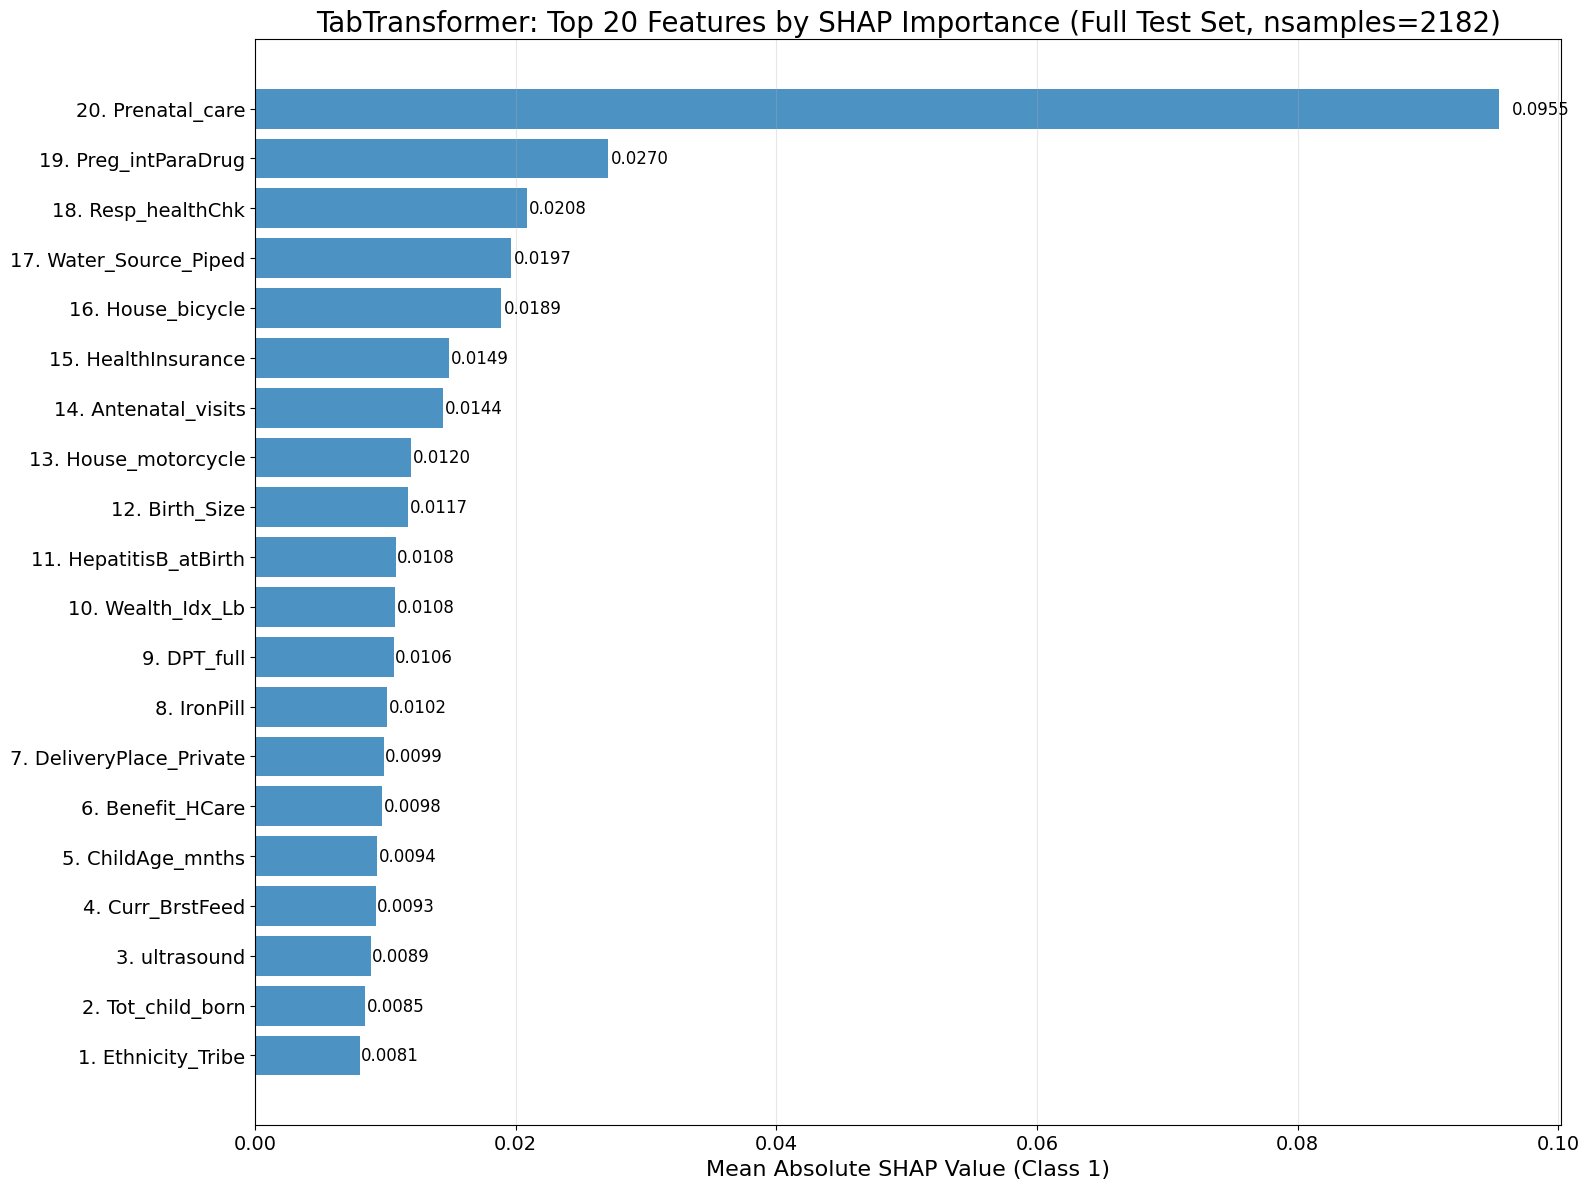

Saved: results/shap_plots/tabtransformer/tabtransformer_top_features_full_ns2182.png

Generating TabTransformer SHAP Summary Plot...


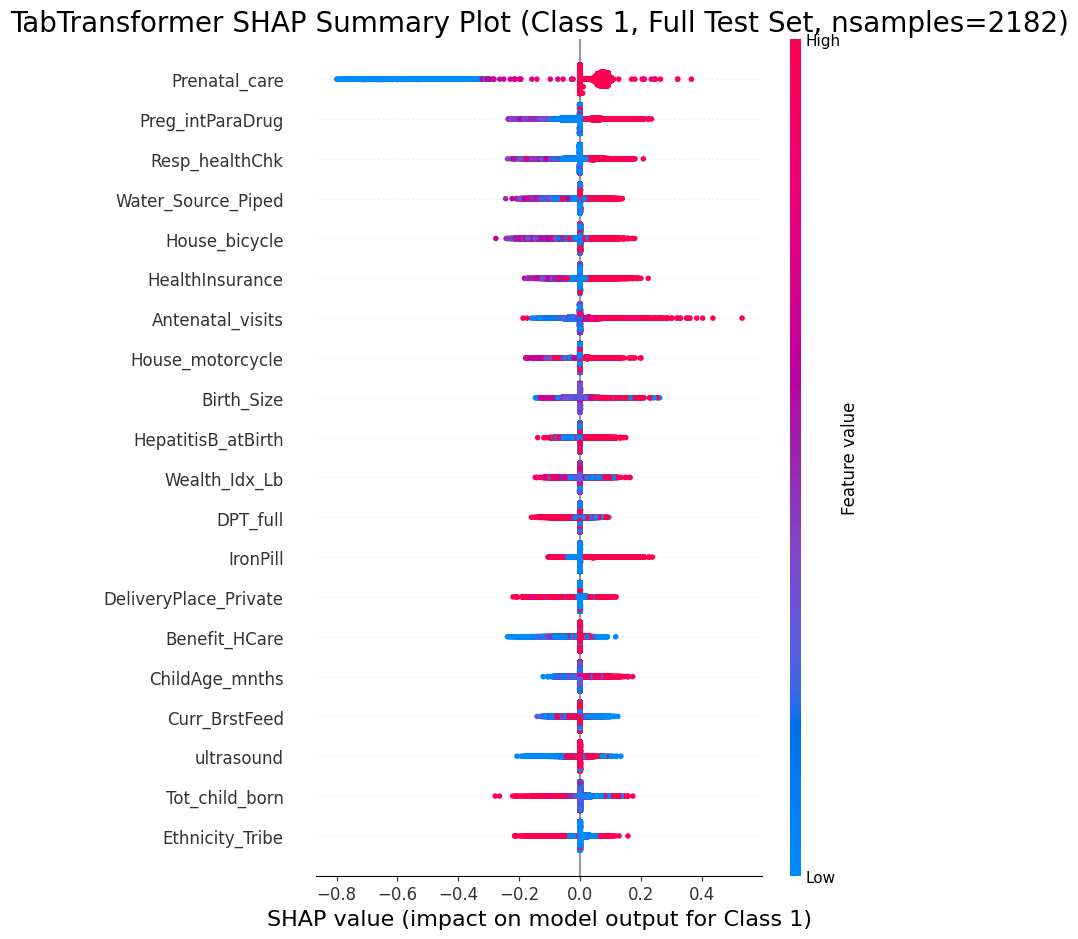

Saved: results/shap_plots/tabtransformer/tabtransformer_shap_summary_full_ns2182.png

Generating TabTransformer waterfall plot for sample index 0...


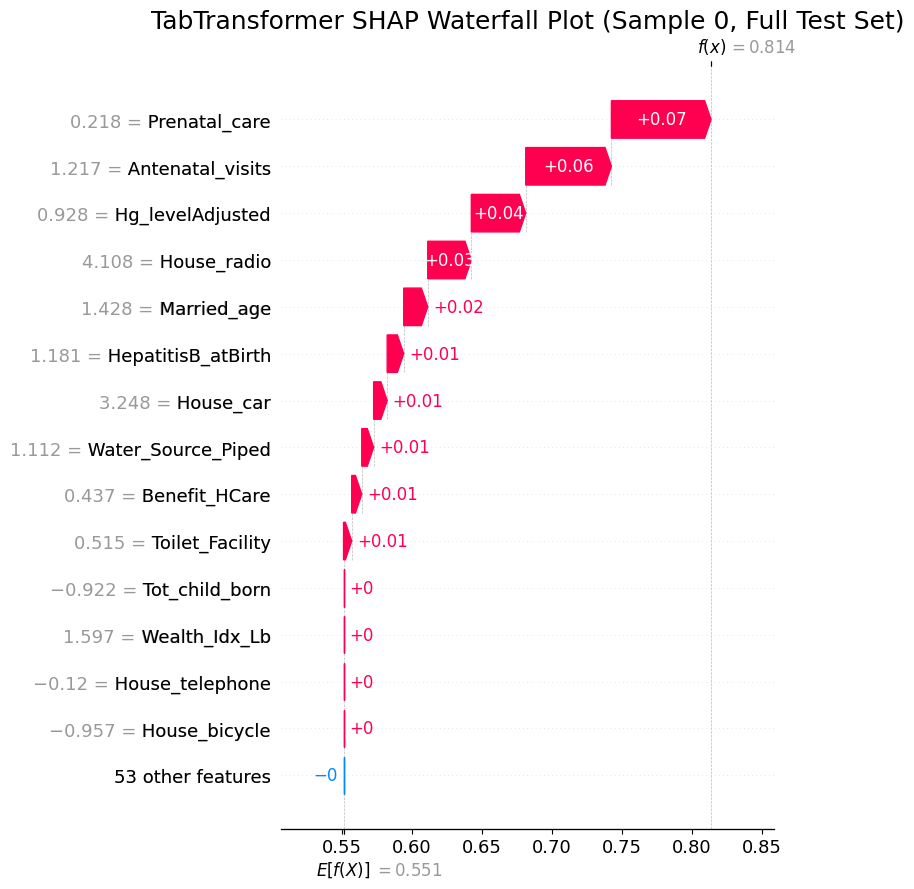

Saved: results/shap_plots/tabtransformer/tabtransformer_waterfall_sample_0_full_ns2182.png

Generating TabTransformer Class Comparison Heatmap...


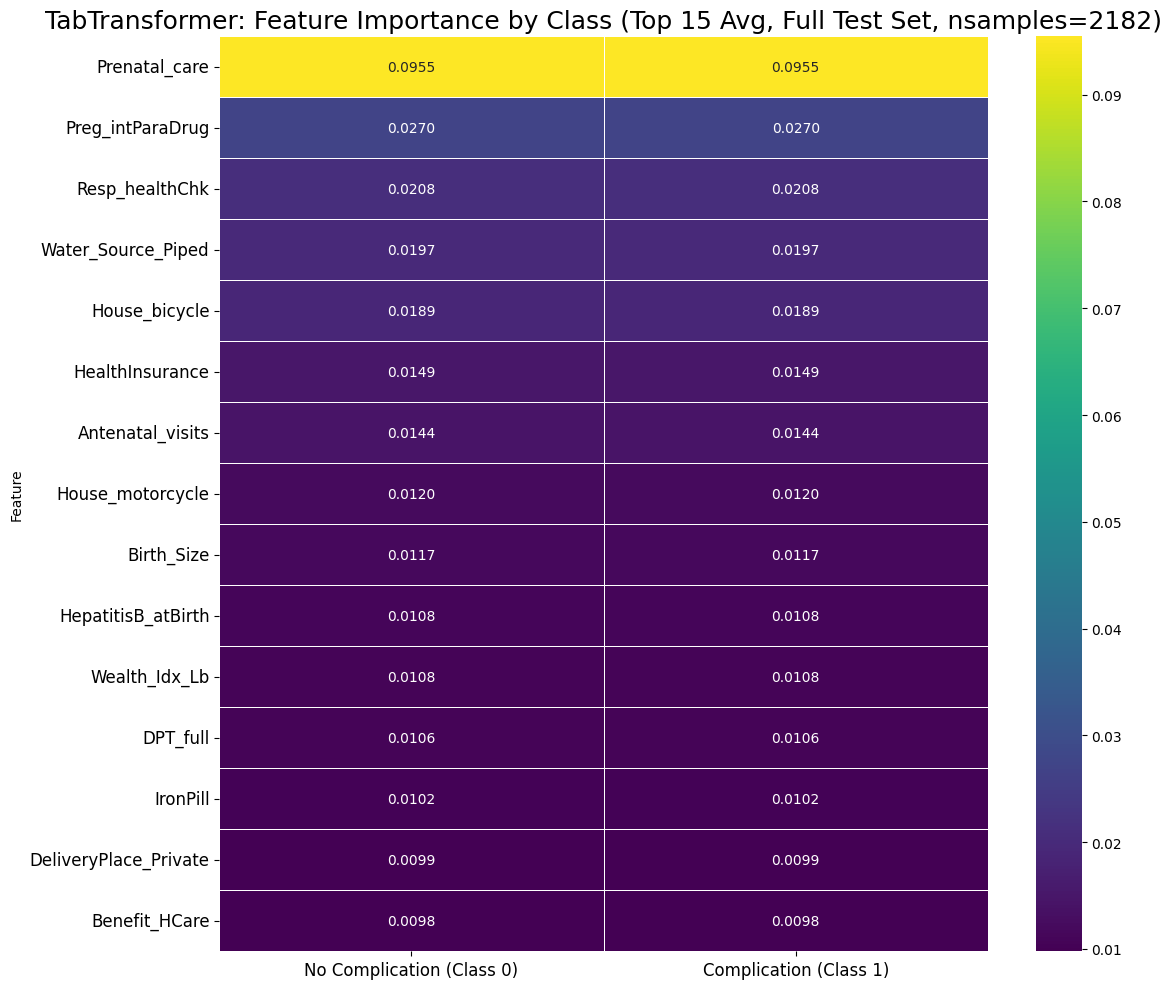

Saved: results/shap_plots/tabtransformer/tabtransformer_class_comparison_full_ns2182.png

TabTransformer visualizations completed successfully (nsamples=2182)!
Clearing memory...
Memory cleared.


In [ ]:
!pip install shap -q

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import gc
import torch
import os
from torch import nn
import time # To time the SHAP calculation
from matplotlib.colors import Normalize

# --- Environment Variable for Memory Allocation ---
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'
print("Set PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True")

# Create directory for TabTransformer SHAP visualizations if it doesn't exist
tab_shap_dir = 'results/shap_plots/tabtransformer/' # Specific directory
os.makedirs(tab_shap_dir, exist_ok=True)

# --- Utility Functions ---
def clear_memory():
    """Clears GPU cache and runs garbage collection."""
    print("Clearing memory...")
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    print("Memory cleared.")

# --- Data and Model Preparation ---
print("\nChecking for necessary variables for TabTransformer SHAP...")
# Need model_tab specifically
required_vars = ['model_tab', 'X_test', 'y_test', 'X_train', 'feature_names',
                 'cat_cols', 'num_cols', 'split_cat_num', 'device']
variables_exist = True
for var in required_vars:
    if var not in globals():
        print(f"Error: Variable '{var}' not found. Please ensure previous steps were run or load data here.")
        variables_exist = False
if not variables_exist:
     raise NameError("Missing required variables for TabTransformer SHAP analysis.")
else:
    print("All necessary variables seem to exist.")

print("\nPreparing data and model for TabTransformer SHAP analysis...")
model_tab.eval() 
model_tab.to(device)

print(f"Attempting SHAP analysis on the FULL X_test dataset with shape: {X_test.shape}")
n_samples_to_explain = X_test.shape[0] 

n_background_samples = 50
if len(X_train) < n_background_samples: n_background_samples = len(X_train)
bg_indices = np.random.choice(len(X_train), n_background_samples, replace=False)
X_background = X_train[bg_indices]
print(f"Shape of X_background: {X_background.shape}")

# Feature names 
n_features = X_test.shape[1]
print(f"Number of features detected: {n_features}")
if not isinstance(feature_names, list): feature_names = list(feature_names)
if len(feature_names) != n_features: print(f"Warning: Mismatch between features ({n_features}) and feature_names ({len(feature_names)}).")
print(f"Shape of X_test (samples to explain): {X_test.shape}") # Using X_test shape

# TabTransformer 
def tab_predict_proba_shap(X):
    """ Prediction wrapper specifically for TabTransformer (model_tab) """
    model_tab.eval() 
    results = []
    try:
        with torch.no_grad():
            X_cat, X_num = split_cat_num(X)
            X_cat_t = torch.tensor(X_cat, dtype=torch.long).to(device)
            X_num_t = torch.tensor(X_num, dtype=torch.float32).to(device)
            logits = model_tab(X_cat_t, X_num_t) 
            probs_class1 = torch.sigmoid(logits).squeeze(-1)
            probs_class0 = 1.0 - probs_class1
            probs_both_classes = torch.stack([probs_class0, probs_class1], dim=1)
            results = probs_both_classes.cpu().numpy()
    except RuntimeError as e:
        if "out of memory" in str(e): print("OOM Error inside prediction wrapper!"); raise e
        else: print(f"RuntimeError inside prediction wrapper: {e}"); raise e
    except Exception as e: print(f"Error inside prediction wrapper: {e}"); raise e
    return results
print("Prediction wrapper for TabTransformer SHAP defined.")

# TabTransformer SHAP 
clear_memory()
print("\n" + "="*50); print("CALCULATING TABTRANSFORMER SHAP VALUES (High Accuracy)"); print("="*50)

explicit_nsamples = 2182
print(f"Using KernelExplainer with {X_background.shape[0]} background samples.")
print(f"Explaining ALL {n_samples_to_explain} instances in X_test.")
print(f"Explicitly setting nsamples = {explicit_nsamples} (High value for accuracy, feasible on A100/40GB for this dataset size).")
print("This might take up to a minute...") 

start_time = time.time()
calculation_successful = False; shape_ok = False
shap_output = None 

try:
    
    tab_explainer = shap.KernelExplainer(tab_predict_proba_shap, X_background)
    shap_output = tab_explainer.shap_values(X_test, nsamples=explicit_nsamples)
    calculation_successful = True
except torch.cuda.OutOfMemoryError:
     print("\n" + "*"*60); print("ERROR: CUDA Out Of Memory occurred."); print(f"nsamples={explicit_nsamples} might be too high even for 40GB if X_test is larger than expected or model is complex."); print("Consider reducing nsamples or partitioning."); print("*"*60)
except Exception as e:
    print(f"\nError during TabTransformer SHAP calculation: {e}")

# Define tab_shap_values 
tab_shap_values = None

if calculation_successful:
    end_time = time.time()
    print(f"TabTransformer SHAP calculation complete in {end_time - start_time:.2f} seconds ({ (end_time - start_time)/60 :.2f} minutes).")

    print("\n--- Processing SHAP Output ---")
    try:
        if isinstance(shap_output, np.ndarray) and shap_output.ndim == 3:
            print(f"Detected NumPy array output with shape: {shap_output.shape}")
            expected_shape_part = (n_samples_to_explain, n_features)
            if shap_output.shape[0:2] == expected_shape_part and shap_output.shape[2] == 2:
                print("Shape matches (samples, features, 2 classes).")
                tab_shap_values = shap_output 
                print(f"Assigned output array to 'tab_shap_values' with shape: {tab_shap_values.shape}")
                shape_ok = True
            else: print(f"ERROR: NumPy array shape {shap_output.shape} mismatch expected ({n_samples_to_explain}, {n_features}, 2).")
        elif isinstance(shap_output, list) and len(shap_output) == 2:
             print("Detected list output."); expected_shape=(n_samples_to_explain,n_features)
             if shap_output[0].shape == expected_shape and shap_output[1].shape == expected_shape:
                 print("List shapes OK. Reconstructing 3D array."); tab_shap_values = np.stack(shap_output, axis=-1); print(f"Reconstructed 'tab_shap_values' shape: {tab_shap_values.shape}"); shape_ok = True
             else: print(f"ERROR: List elements have unexpected shapes: {shap_output[0].shape}, {shap_output[1].shape}")
        else: print(f"ERROR: Unexpected output type/structure: {type(shap_output)}")
    except Exception as e: print(f"Error processing SHAP output: {e}")
    print("--- End Processing ---")
    clear_memory()

if calculation_successful and shape_ok and tab_shap_values is not None:

    print("\n" + "="*50); print("TABTRANSFORMER MINIMAL SHAP VISUALIZATION"); print("="*50)
    print(f"Note: Visualizations based on nsamples={explicit_nsamples} on {n_samples_to_explain} samples.")

    try: 
        feature_importance = np.abs(tab_shap_values[:, :, 1]).mean(axis=0) 
        print(f"Calculated feature_importance shape: {feature_importance.shape}")
        if len(feature_names) == len(feature_importance):
             importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
             dataframe_creation_successful = True
        else: print(f"ERROR: Length mismatch: len(feature_names)={len(feature_names)}, len(feature_importance)={len(feature_importance)}"); dataframe_creation_successful = False
    except Exception as e: print(f"Error calculating importance or creating DataFrame: {e}"); dataframe_creation_successful = False

    if dataframe_creation_successful:
        importance_df = importance_df.sort_values('Importance', ascending=False).reset_index(drop=True)
        print("\nTabTransformer: Top 20 Features by SHAP Importance:")
        print(importance_df.head(20))
        top_n = min(20, len(importance_df))
        top_features = importance_df['Feature'].head(top_n).tolist()
        top_indices = [list(feature_names).index(f) for f in top_features]

        current_nsamples = explicit_nsamples
        file_suffix = f"_full_ns{current_nsamples}" 

        # 1. Feature importance bar plot (TabTransformer)
        plt.figure(figsize=(16, 12))
        bars = plt.barh(np.arange(top_n), importance_df['Importance'].head(top_n)[::-1], color='#1f77b4', alpha=0.8)
        labels = [f"{i+1}. {f}" for i, f in enumerate(importance_df['Feature'].head(top_n)[::-1])]
        plt.yticks(np.arange(top_n), labels, fontsize=14)
        for i, bar in enumerate(bars): plt.text(bar.get_width() + bar.get_width()*0.01, bar.get_y()+bar.get_height()/2, f"{importance_df['Importance'].head(top_n)[::-1].iloc[i]:.4f}", va='center', fontsize=12)
        plt.title(f'TabTransformer: Top {top_n} Features by SHAP Importance (Full Test Set, nsamples={current_nsamples})', fontsize=20)
        plt.xlabel('Mean Absolute SHAP Value (Class 1)', fontsize=16); plt.xticks(fontsize=14); plt.grid(axis='x', alpha=0.3); plt.tight_layout()
        save_path = os.path.join(tab_shap_dir, f'tabtransformer_top_features{file_suffix}.png')
        plt.savefig(save_path, dpi=300, bbox_inches='tight'); plt.show()
        print(f"Saved: {save_path}")

        # 2. SHAP summary plot (TabTransformer) 
        tab_shap_values_class1 = tab_shap_values[:, :, 1] 
        if tab_shap_values_class1.shape == (n_samples_to_explain, n_features):
            print("\nGenerating TabTransformer SHAP Summary Plot...")
            plt.figure(); shap.summary_plot(tab_shap_values_class1, X_test, feature_names=feature_names, max_display=top_n, plot_type="dot", show=False, color_bar=True) # Use X_test
            plt.title(f'TabTransformer SHAP Summary Plot (Class 1, Full Test Set, nsamples={current_nsamples})', fontsize=20)
            plt.xlabel('SHAP value (impact on model output for Class 1)', fontsize=16); plt.yticks(fontsize=12); plt.xticks(fontsize=12); plt.tight_layout()
            save_path = os.path.join(tab_shap_dir, f'tabtransformer_shap_summary{file_suffix}.png')
            plt.savefig(save_path, dpi=300, bbox_inches='tight'); plt.show()
            print(f"Saved: {save_path}")
        else: print(f"Skipping Summary plot due to unexpected shape: {tab_shap_values_class1.shape}")

        # 3. Waterfall plot (TabTransformer)
        sample_idx_waterfall = 0
        print(f"\nGenerating TabTransformer waterfall plot for sample index {sample_idx_waterfall}...")
        try:
             if hasattr(tab_explainer, 'expected_value') and isinstance(tab_explainer.expected_value, (list, np.ndarray)) and len(tab_explainer.expected_value) == 2:
                  tab_expected_value_class1 = tab_explainer.expected_value[1]; can_plot_waterfall = True
             else: print(f"Could not plot waterfall: tab_explainer.expected_value missing or unexpected: {getattr(tab_explainer, 'expected_value', 'Not Found')}"); can_plot_waterfall = False

             if can_plot_waterfall and tab_shap_values_class1.shape == (n_samples_to_explain, n_features):
                 explanation_obj = shap.Explanation(values=tab_shap_values_class1[sample_idx_waterfall,:], base_values=tab_expected_value_class1, data=X_test[sample_idx_waterfall,:], feature_names=feature_names) 
                 plt.figure(); shap.waterfall_plot(explanation_obj, max_display=15, show=False)
                 plt.title(f'TabTransformer SHAP Waterfall Plot (Sample {sample_idx_waterfall}, Full Test Set)', fontsize=18); plt.tight_layout()
                 save_path = os.path.join(tab_shap_dir, f'tabtransformer_waterfall_sample_{sample_idx_waterfall}{file_suffix}.png')
                 plt.savefig(save_path, dpi=300, bbox_inches='tight'); plt.show()
                 print(f"Saved: {save_path}")
             elif can_plot_waterfall: print(f"Skipping Waterfall plot due to unexpected shape: {tab_shap_values_class1.shape}")
        except Exception as e: print(f"Could not generate waterfall plot for sample {sample_idx_waterfall}: {e}")

        # 4. Feature importance heatmap (TabTransformer)
        print("\nGenerating TabTransformer Class Comparison Heatmap...")
        try:
            tab_shap_values_class0 = tab_shap_values[:, :, 0]
            if tab_shap_values_class0.shape == (n_samples_to_explain, n_features):
                tab_class0_importance = np.abs(tab_shap_values_class0).mean(axis=0); heatmap_possible = True
            else: print(f"Cannot generate heatmap: SHAP values class 0 wrong shape ({tab_shap_values_class0.shape})."); heatmap_possible = False

            if heatmap_possible and dataframe_creation_successful:
                fig_heatmap, ax_heatmap = plt.subplots(figsize=(12, 10))
                tab_class_comparison = pd.DataFrame({'Feature': feature_names, 'No Complication (Class 0)': tab_class0_importance, 'Complication (Class 1)': feature_importance}) 
                tab_class_comparison['Average'] = (tab_class_comparison['No Complication (Class 0)'] + tab_class_comparison['Complication (Class 1)']) / 2
                tab_class_comparison = tab_class_comparison.sort_values('Average', ascending=False)
                n_heatmap_features = min(15, len(feature_names))
                tab_class_comparison_top = tab_class_comparison.head(n_heatmap_features).drop('Average', axis=1)
                heatmap_data_tab = tab_class_comparison_top.set_index('Feature')
                sns.heatmap(heatmap_data_tab, cmap='viridis', annot=True, fmt='.4f', linewidths=.5, ax=ax_heatmap, annot_kws={"size": 10})
                ax_heatmap.set_title(f'TabTransformer: Feature Importance by Class (Top {n_heatmap_features} Avg, Full Test Set, nsamples={current_nsamples})', fontsize=18)
                ax_heatmap.tick_params(axis='y', rotation=0, labelsize=12); ax_heatmap.tick_params(axis='x', labelsize=12); plt.tight_layout()
                save_path = os.path.join(tab_shap_dir, f'tabtransformer_class_comparison{file_suffix}.png')
                plt.savefig(save_path, dpi=300, bbox_inches='tight'); plt.show()
                print(f"Saved: {save_path}")
            elif not dataframe_creation_successful: print("Skipping heatmap: importance DataFrame missing.")
            else: print("Skipping heatmap: importance class 0 missing/wrong shape.")
        except Exception as e: print(f"Could not generate class comparison heatmap: {e}")

        print(f"\nTabTransformer visualizations completed successfully (nsamples={current_nsamples})!")

    else: 
         print("\nCould not generate visualizations because the importance DataFrame could not be created.")

else: 
    print("\nSkipping visualizations because TabTransformer SHAP calculation failed or produced unusable output.")


clear_memory()

# Step 12: SHAP Analysis for FT-Transformer

Set PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True

Checking for necessary variables for FT-Transformer SHAP...
All necessary variables seem to exist.

Preparing data and model for FT-Transformer SHAP analysis...
Attempting SHAP analysis on the FULL X_test dataset with shape: (41077, 67)
Shape of X_background: (50, 67)
Number of features detected: 67
Shape of X_test (samples to explain): (41077, 67)
Prediction wrapper for FT-Transformer SHAP defined.
Clearing memory...
Memory cleared.

CALCULATING FT-TRANSFORMER SHAP VALUES (Full Test Set, Target Runtime ~1hr)
Using KernelExplainer with 50 background samples.
Explaining ALL 41077 instances in X_test.
Explicitly setting nsamples = 200 (Targeting ~1hr runtime, reduced accuracy).
This should take approximately 60-70 minutes...


  0%|          | 0/41077 [00:00<?, ?it/s]

FT-Transformer SHAP calculation complete in 4414.21 seconds (73.57 minutes).

--- Processing SHAP Output ---
Detected NumPy array output with shape: (41077, 67, 2)
Shape matches (samples, features, 2 classes). Slicing...
Shape of extracted ft_shap_values_class0: (41077, 67)
Shape of extracted ft_shap_values_class1: (41077, 67)
--- End Processing ---
Clearing memory...
Memory cleared.

GENERATING FT-TRANSFORMER SHAP VISUALIZATIONS
Note: Visualizations based on nsamples=200 on the full test set.
Calculating feature importance from ft_shap_values_class1 with shape: (41077, 67)
Shape of calculated ft_feature_importance: (67,)
Length of feature_names: 67
Length of ft_feature_importance: 67
Importance DataFrame created successfully.

FT-Transformer: Top 20 Features by SHAP Importance (Full Test Set):
                  Feature  Importance
0           Prenatal_care    0.077928
1            Child_under5    0.031244
2              Birth_Size    0.024511
3        Preg_intParaDrug    0.023521
4   

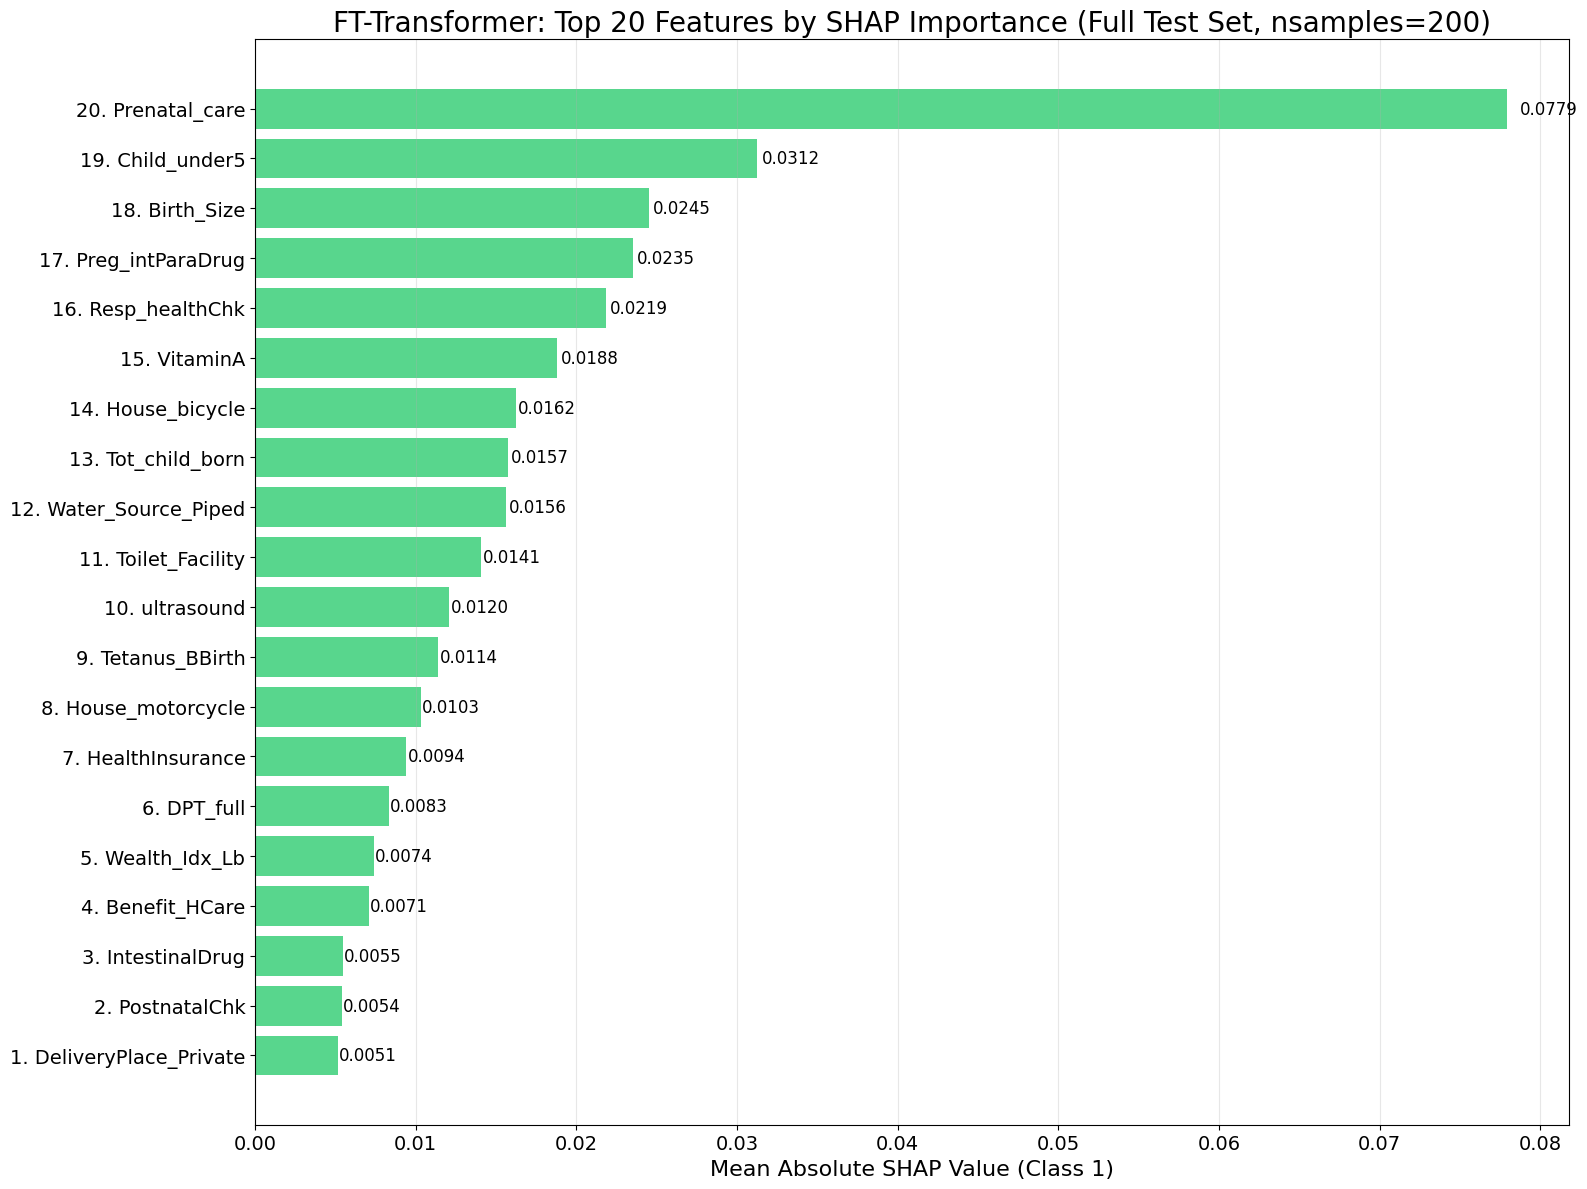

Saved: results/shap_plots/fttransformer/fttransformer_top_features_full_ns200.png

Generating SHAP Summary Plot...


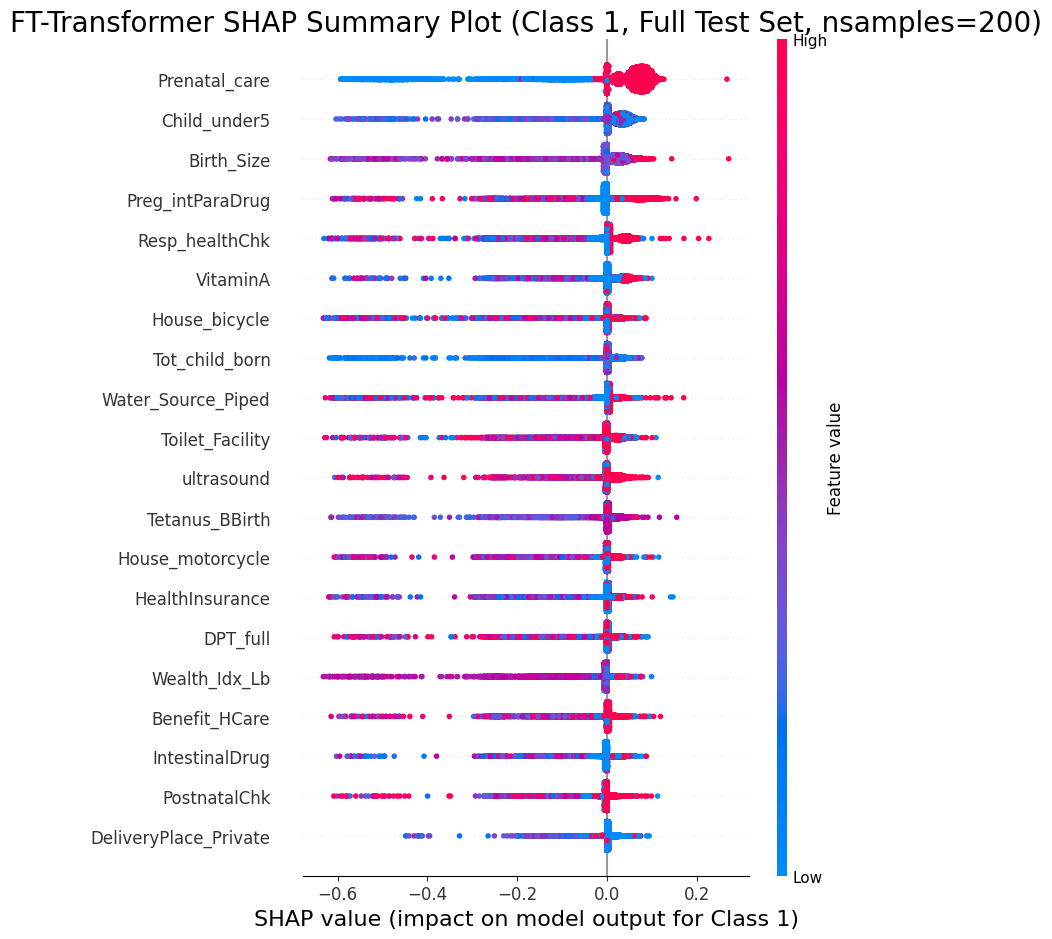

Saved: results/shap_plots/fttransformer/fttransformer_shap_summary_full_ns200.png

Generating waterfall plot for sample index 0 from X_test...


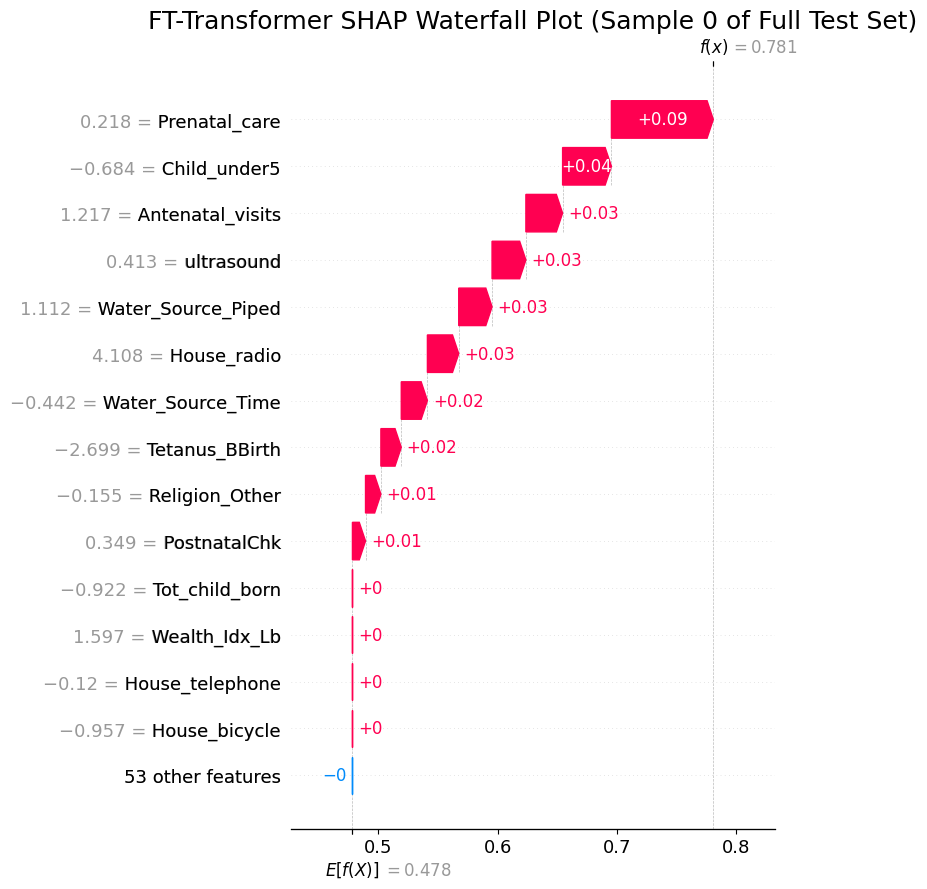

Saved: results/shap_plots/fttransformer/fttransformer_waterfall_sample_0_full_ns200.png

Generating Class Comparison Heatmap...


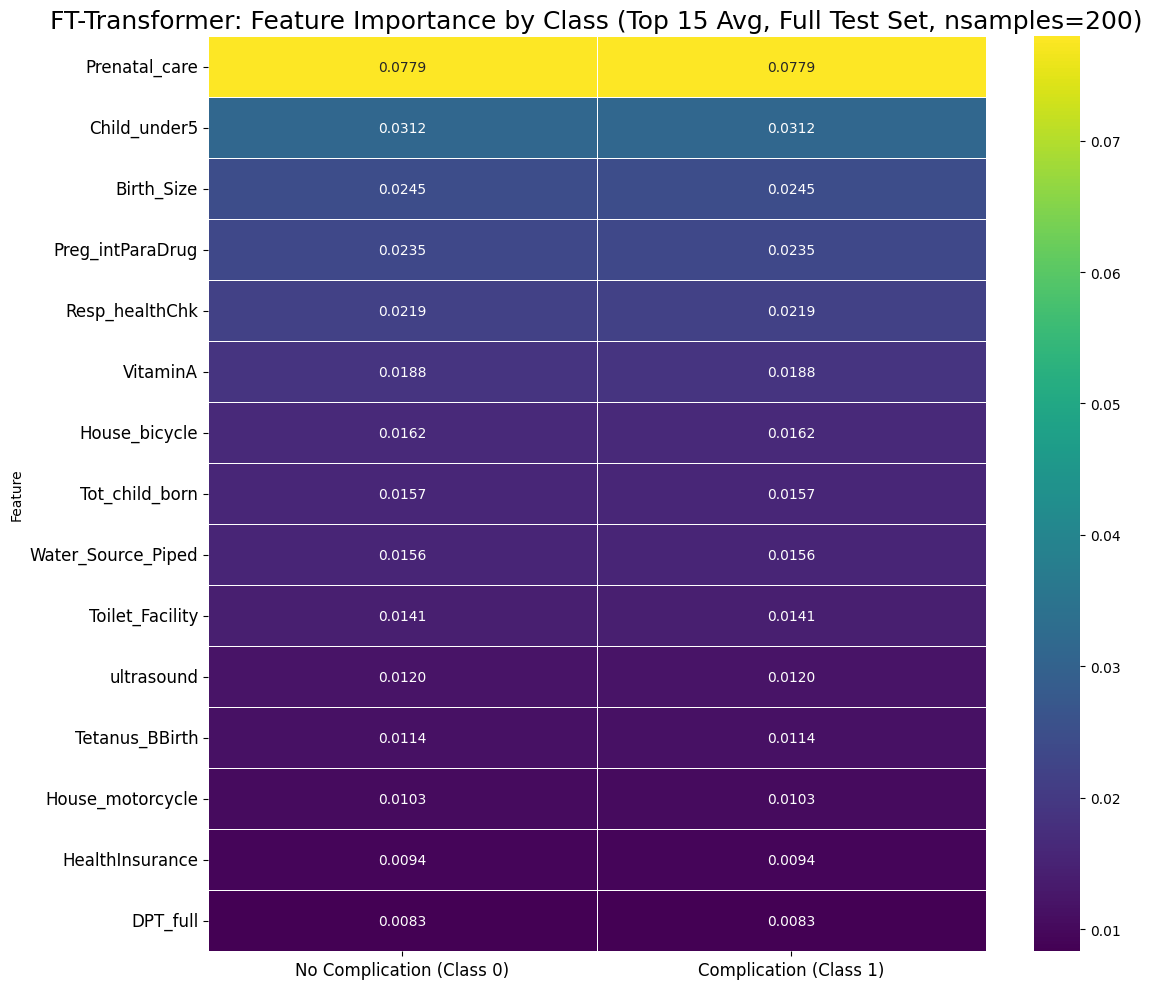

Saved: results/shap_plots/fttransformer/fttransformer_class_comparison_full_ns200.png

FT-Transformer SHAP visualization generation complete (nsamples=200)!
Clearing memory...
Memory cleared.


In [ ]:


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import gc
import torch
import os
from torch import nn
import time 
from matplotlib.colors import Normalize

os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'
print("Set PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True")

ft_shap_dir = 'results/shap_plots/fttransformer/'
os.makedirs(ft_shap_dir, exist_ok=True)

def clear_memory():
    """Clears GPU cache and runs garbage collection."""
    print("Clearing memory...")
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    print("Memory cleared.")

print("\nChecking for necessary variables for FT-Transformer SHAP...")
required_vars = ['model_ft', 'X_test', 'y_test', 'X_train', 'feature_names',
                 'cat_cols', 'num_cols', 'split_cat_num', 'device']
variables_exist = True
for var in required_vars:
    if var not in globals():
        print(f"Error: Variable '{var}' not found. Please ensure previous steps were run or load data here.")
        variables_exist = False
if not variables_exist:
     raise NameError("Missing required variables for FT-Transformer SHAP analysis.")
else:
    print("All necessary variables seem to exist.")

print("\nPreparing data and model for FT-Transformer SHAP analysis...")
model_ft.eval() 
model_ft.to(device)

print(f"Attempting SHAP analysis on the FULL X_test dataset with shape: {X_test.shape}")
n_samples_to_explain = X_test.shape[0] 

n_background_samples = 50
if len(X_train) < n_background_samples: n_background_samples = len(X_train)
bg_indices = np.random.choice(len(X_train), n_background_samples, replace=False)
X_background = X_train[bg_indices]
print(f"Shape of X_background: {X_background.shape}")

# Feature names 
n_features = X_test.shape[1]
print(f"Number of features detected: {n_features}")
if not isinstance(feature_names, list): feature_names = list(feature_names)
if len(feature_names) != n_features: print(f"Warning: Mismatch between features ({n_features}) and feature_names ({len(feature_names)}).")
print(f"Shape of X_test (samples to explain): {X_test.shape}")

# FT-Transformer
def ft_predict_proba_shap(X):
    model_ft.eval(); results = []
    try:
        with torch.no_grad():
            X_cat, X_num = split_cat_num(X)
            X_cat_t = torch.tensor(X_cat, dtype=torch.long).to(device)
            X_num_t = torch.tensor(X_num, dtype=torch.float32).to(device)
            logits = model_ft(X_cat_t, X_num_t) # Use model_ft
            probs_class1 = torch.sigmoid(logits).squeeze(-1)
            probs_class0 = 1.0 - probs_class1
            probs_both_classes = torch.stack([probs_class0, probs_class1], dim=1)
            results = probs_both_classes.cpu().numpy()
    except RuntimeError as e:
        if "out of memory" in str(e): print("OOM Error inside prediction wrapper!"); raise e
        else: print(f"RuntimeError inside prediction wrapper: {e}"); raise e
    except Exception as e: print(f"Error inside prediction wrapper: {e}"); raise e
    return results
print("Prediction wrapper for FT-Transformer SHAP defined.")

clear_memory()
print("\n" + "="*50); print("CALCULATING FT-TRANSFORMER SHAP VALUES (Full Test Set, Target Runtime ~1hr)"); print("="*50)

# !! REDUCED NSAMPLES = 200 for ~1hr Runtime !!
# Further reducing nsamples to meet time constraints. Accuracy reduced vs higher values.
explicit_nsamples = 200 # Reduced from 500
print(f"Using KernelExplainer with {X_background.shape[0]} background samples.")
print(f"Explaining ALL {n_samples_to_explain} instances in X_test.")
print(f"Explicitly setting nsamples = {explicit_nsamples} (Targeting ~1hr runtime, reduced accuracy).")
print("This should take approximately 60-70 minutes...") # Update estimate

start_time = time.time()
calculation_successful = False; shape_ok = False
shap_output = None

try:
    # Create explainer for FT-Transformer
    ft_explainer = shap.KernelExplainer(ft_predict_proba_shap, X_background)
    shap_output = ft_explainer.shap_values(X_test, nsamples=explicit_nsamples)
    calculation_successful = True
except torch.cuda.OutOfMemoryError:
     print("\n" + "*"*60); print("ERROR: CUDA Out Of Memory occurred."); print(f"Even nsamples={explicit_nsamples} might be too high for FT-Transformer on this dataset size."); print("Consider further reducing nsamples or partitioning."); print("*"*60)
except Exception as e:
    print(f"\nError during FT-Transformer SHAP calculation: {e}")

ft_shap_values_class0 = None
ft_shap_values_class1 = None

if calculation_successful:
    end_time = time.time()
    print(f"FT-Transformer SHAP calculation complete in {end_time - start_time:.2f} seconds ({ (end_time - start_time)/60 :.2f} minutes).")

    print("\n--- Processing SHAP Output ---")
    try:
        # Check if output matches the expected 3D numpy array format
        if isinstance(shap_output, np.ndarray) and shap_output.ndim == 3:
            print(f"Detected NumPy array output with shape: {shap_output.shape}")
            expected_shape_part = (n_samples_to_explain, n_features)
            if shap_output.shape[0:2] == expected_shape_part and shap_output.shape[2] == 2:
                print("Shape matches (samples, features, 2 classes). Slicing...")
                ft_shap_values_class0 = shap_output[:, :, 0]
                ft_shap_values_class1 = shap_output[:, :, 1]
                print(f"Shape of extracted ft_shap_values_class0: {ft_shap_values_class0.shape}")
                print(f"Shape of extracted ft_shap_values_class1: {ft_shap_values_class1.shape}")
                shape_ok = True
            else: print(f"ERROR: NumPy array shape {shap_output.shape} mismatch expected ({n_samples_to_explain}, {n_features}, 2).")
        elif isinstance(shap_output, list) and len(shap_output) == 2:
             print("Detected list output."); expected_shape=(n_samples_to_explain,n_features)
             if shap_output[0].shape == expected_shape and shap_output[1].shape == expected_shape:
                 print("List shapes OK."); ft_shap_values_class0 = shap_output[0]; ft_shap_values_class1 = shap_output[1]; shape_ok = True
             else: print(f"ERROR: List elements have unexpected shapes: {shap_output[0].shape}, {shap_output[1].shape}")
        else: print(f"ERROR: Unexpected output type/structure: {type(shap_output)}")
    except Exception as e: print(f"Error processing SHAP output: {e}")
    print("--- End Processing ---")
    clear_memory()

if calculation_successful and shape_ok and ft_shap_values_class1 is not None:

    print("\n" + "="*50); print("GENERATING FT-TRANSFORMER SHAP VISUALIZATIONS"); print("="*50)
    
    current_nsamples = explicit_nsamples
    print(f"Note: Visualizations based on nsamples={current_nsamples} on the full test set.")

    dataframe_creation_successful = False; importance_calculated = False
    try:
        print(f"Calculating feature importance from ft_shap_values_class1 with shape: {ft_shap_values_class1.shape}")
        ft_feature_importance = np.abs(ft_shap_values_class1).mean(axis=0)
        importance_calculated = True
        print(f"Shape of calculated ft_feature_importance: {ft_feature_importance.shape}")
        print(f"Length of feature_names: {len(feature_names)}")
        print(f"Length of ft_feature_importance: {len(ft_feature_importance)}")

        if len(feature_names) == len(ft_feature_importance):
            ft_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': ft_feature_importance})
            dataframe_creation_successful = True; print("Importance DataFrame created successfully.")
        else: print("ERROR: Length mismatch. Cannot create DataFrame.")
    except Exception as e: print(f"\nError during importance calculation or DataFrame creation: {e}")

    if dataframe_creation_successful:
        ft_importance_df = ft_importance_df.sort_values('Importance', ascending=False).reset_index(drop=True)
        print("\nFT-Transformer: Top 20 Features by SHAP Importance (Full Test Set):")
        print(ft_importance_df.head(20))
        top_n = min(20, len(ft_importance_df))
        ft_top_features = ft_importance_df['Feature'].head(top_n).tolist()

        file_suffix = f"_full_ns{current_nsamples}" 

        # 1. Feature importance bar plot (FT-Transformer)
        try:
            plt.figure(figsize=(16, 12))
            ft_bars=plt.barh(np.arange(top_n),ft_importance_df['Importance'].head(top_n)[::-1],color='#2ecc71',alpha=0.8) # Green
            ft_labels=[f"{i+1}. {f}" for i,f in enumerate(ft_importance_df['Feature'].head(top_n)[::-1])]
            plt.yticks(np.arange(top_n),ft_labels,fontsize=14)
            for i,bar in enumerate(ft_bars):plt.text(bar.get_width()+bar.get_width()*0.01,bar.get_y()+bar.get_height()/2,f"{ft_importance_df['Importance'].head(top_n)[::-1].iloc[i]:.4f}",va='center',fontsize=12)
            plt.title(f'FT-Transformer: Top {top_n} Features by SHAP Importance (Full Test Set, nsamples={current_nsamples})',fontsize=20)
            plt.xlabel('Mean Absolute SHAP Value (Class 1)',fontsize=16);plt.xticks(fontsize=14);plt.grid(axis='x',alpha=0.3);plt.tight_layout()
            save_path = os.path.join(ft_shap_dir, f'fttransformer_top_features{file_suffix}.png')
            plt.savefig(save_path, dpi=300, bbox_inches='tight'); plt.show()
            print(f"Saved: {save_path}")
        except Exception as e: print(f"Error generating Feature Importance Plot: {e}")

        # 2. SHAP summary plot (dot plot) (FT-Transformer)
        if ft_shap_values_class1.shape == (X_test.shape[0], X_test.shape[1]):
            print("\nGenerating SHAP Summary Plot...")
            try:
                plt.figure(); shap.summary_plot(ft_shap_values_class1, X_test, feature_names=feature_names, max_display=top_n, plot_type="dot", show=False, color_bar=True) # Use X_test
                plt.title(f'FT-Transformer SHAP Summary Plot (Class 1, Full Test Set, nsamples={current_nsamples})', fontsize=20); plt.xlabel('SHAP value (impact on model output for Class 1)', fontsize=16)
                plt.yticks(fontsize=12); plt.xticks(fontsize=12); plt.tight_layout()
                save_path = os.path.join(ft_shap_dir, f'fttransformer_shap_summary{file_suffix}.png')
                plt.savefig(save_path, dpi=300, bbox_inches='tight'); plt.show()
                print(f"Saved: {save_path}")
            except Exception as e: print(f"Error generating Summary Plot: {e}")
        else: print(f"Skipping SHAP Summary Plot due to shape mismatch: SHAP values {ft_shap_values_class1.shape} vs X_test {X_test.shape}")

        # 3. Waterfall plot for a sample (FT-Transformer)
        sample_idx_waterfall = 0
        print(f"\nGenerating waterfall plot for sample index {sample_idx_waterfall} from X_test...")
        try:
            if 'ft_explainer' in globals() and hasattr(ft_explainer, 'expected_value') and isinstance(ft_explainer.expected_value, (list, np.ndarray)) and len(ft_explainer.expected_value) == 2:
                 ft_expected_value_class1 = ft_explainer.expected_value[1]; can_plot_waterfall = True
            else: print(f"Could not plot waterfall: 'ft_explainer' or 'expected_value' missing/invalid."); can_plot_waterfall = False

            if can_plot_waterfall and ft_shap_values_class1.shape == (X_test.shape[0], X_test.shape[1]):
                if sample_idx_waterfall < X_test.shape[0]:
                     explanation_obj = shap.Explanation(values=ft_shap_values_class1[sample_idx_waterfall,:], base_values=ft_expected_value_class1, data=X_test[sample_idx_waterfall,:], feature_names=feature_names) # Use X_test
                     plt.figure(); shap.waterfall_plot(explanation_obj, max_display=15, show=False)
                     plt.title(f'FT-Transformer SHAP Waterfall Plot (Sample {sample_idx_waterfall} of Full Test Set)', fontsize=18); plt.tight_layout()
                     save_path = os.path.join(ft_shap_dir, f'fttransformer_waterfall_sample_{sample_idx_waterfall}{file_suffix}.png')
                     plt.savefig(save_path, dpi=300, bbox_inches='tight'); plt.show()
                     print(f"Saved: {save_path}")
                else: print(f"Skipping waterfall plot: sample index {sample_idx_waterfall} out of bounds for X_test size {X_test.shape[0]}.")
            elif can_plot_waterfall: print(f"Skipping SHAP Waterfall Plot due to SHAP values shape mismatch: {ft_shap_values_class1.shape} vs X_test {X_test.shape}")
        except Exception as e: print(f"Could not generate waterfall plot for sample {sample_idx_waterfall}: {e}")

        # 4. Feature importance heatmap (FT-Transformer)
        print("\nGenerating Class Comparison Heatmap...")
        try:
            if 'ft_shap_values_class0' in globals() and ft_shap_values_class0 is not None and ft_shap_values_class0.shape == (X_test.shape[0], X_test.shape[1]):
                ft_class0_importance = np.abs(ft_shap_values_class0).mean(axis=0); heatmap_possible = True
            else: print(f"Cannot generate heatmap: SHAP values for class 0 missing or wrong shape."); heatmap_possible = False

            if heatmap_possible and dataframe_creation_successful:
                fig_heatmap, ax_heatmap = plt.subplots(figsize=(12, 10))
                ft_class_comparison = pd.DataFrame({'Feature': feature_names, 'No Complication (Class 0)': ft_class0_importance, 'Complication (Class 1)': ft_feature_importance})
                ft_class_comparison['Average'] = (ft_class_comparison['No Complication (Class 0)'] + ft_class_comparison['Complication (Class 1)']) / 2
                ft_class_comparison = ft_class_comparison.sort_values('Average', ascending=False)
                n_heatmap_features = min(15, len(feature_names))
                ft_class_comparison_top = ft_class_comparison.head(n_heatmap_features).drop('Average', axis=1)
                heatmap_data_ft = ft_class_comparison_top.set_index('Feature')
                sns.heatmap(heatmap_data_ft, cmap='viridis', annot=True, fmt='.4f', linewidths=.5, ax=ax_heatmap, annot_kws={"size": 10})
                ax_heatmap.set_title(f'FT-Transformer: Feature Importance by Class (Top {n_heatmap_features} Avg, Full Test Set, nsamples={current_nsamples})', fontsize=18)
                ax_heatmap.tick_params(axis='y', rotation=0, labelsize=12); ax_heatmap.tick_params(axis='x', labelsize=12); plt.tight_layout()
                save_path = os.path.join(ft_shap_dir, f'fttransformer_class_comparison{file_suffix}.png')
                plt.savefig(save_path, dpi=300, bbox_inches='tight'); plt.show()
                print(f"Saved: {save_path}")
            elif not dataframe_creation_successful: print("Skipping heatmap: importance DataFrame missing.")
            else: print("Skipping heatmap: importance class 0 missing/invalid.")
        except Exception as e: print(f"Could not generate class comparison heatmap: {e}")

        print(f"\nFT-Transformer SHAP visualization generation complete (nsamples={current_nsamples})!")

    else: 
         print("\nCould not generate visualizations because the importance DataFrame could not be created.")

else: 
    print("\nSkipping SHAP processing and visualizations because FT-Transformer SHAP calculation failed or produced unusable output.")

clear_memory()

# Step 13: TabNet Model SHAP Analysis

Set PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True

Checking for necessary variables for TabNet SHAP...
All necessary variables seem to exist.

Preparing data and model for TabNet SHAP analysis...
Preparing X_test and X_background in TabNet input format...
Shape of X_test_tabnet (samples to explain): (41077, 68)
Shape of X_background_tabnet: (50, 68)
Initial number of TabNet feature names: 67
Correcting feature name list length mismatch (67 vs 68).
Added dummy categorical feature name: dummy_categorical_0
Final number of TabNet feature names: 68
Prediction wrapper for TabNet SHAP defined.
Clearing memory...
Memory cleared.

CALCULATING TABNET SHAP VALUES (Full Test Set, nsamples=60)
Using KernelExplainer with 50 background samples.
Explaining ALL 41077 instances in X_test_tabnet.
Explicitly setting nsamples = 60 (Reduced drastically for <1hr runtime).
Estimated runtime ~1 hour or less...


  0%|          | 0/41077 [00:00<?, ?it/s]

TabNet SHAP calculation complete in 4442.59 seconds (74.04 minutes).

--- Processing SHAP Output ---
Detected NumPy array output with shape: (41077, 68, 2)
Shape matches (samples, features, 2 classes). Slicing...
Shape of extracted tabnet_shap_values_class0: (41077, 68)
Shape of extracted tabnet_shap_values_class1: (41077, 68)
--- End Processing ---
Clearing memory...
Memory cleared.

GENERATING TABNET SHAP VISUALIZATIONS
Note: Visualizations based on nsamples=60 on the full test set.
Calculating feature importance from tabnet_shap_values_class1 with shape: (41077, 68)
Shape of calculated tabnet_feature_importance: (68,)
Length of tabnet_feature_names: 68
Length of tabnet_feature_importance: 68
DataFrame created successfully.

TabNet: Top 20 Features by SHAP Importance (Full Test Set):
                  Feature    Importance
0          Resp_healthChk  6.677830e+10
1          IntestinalDrug  6.677830e+10
2        ChildFood_bottle  6.677830e+10
3          ChildAge_mnths  6.677830e+10
4  

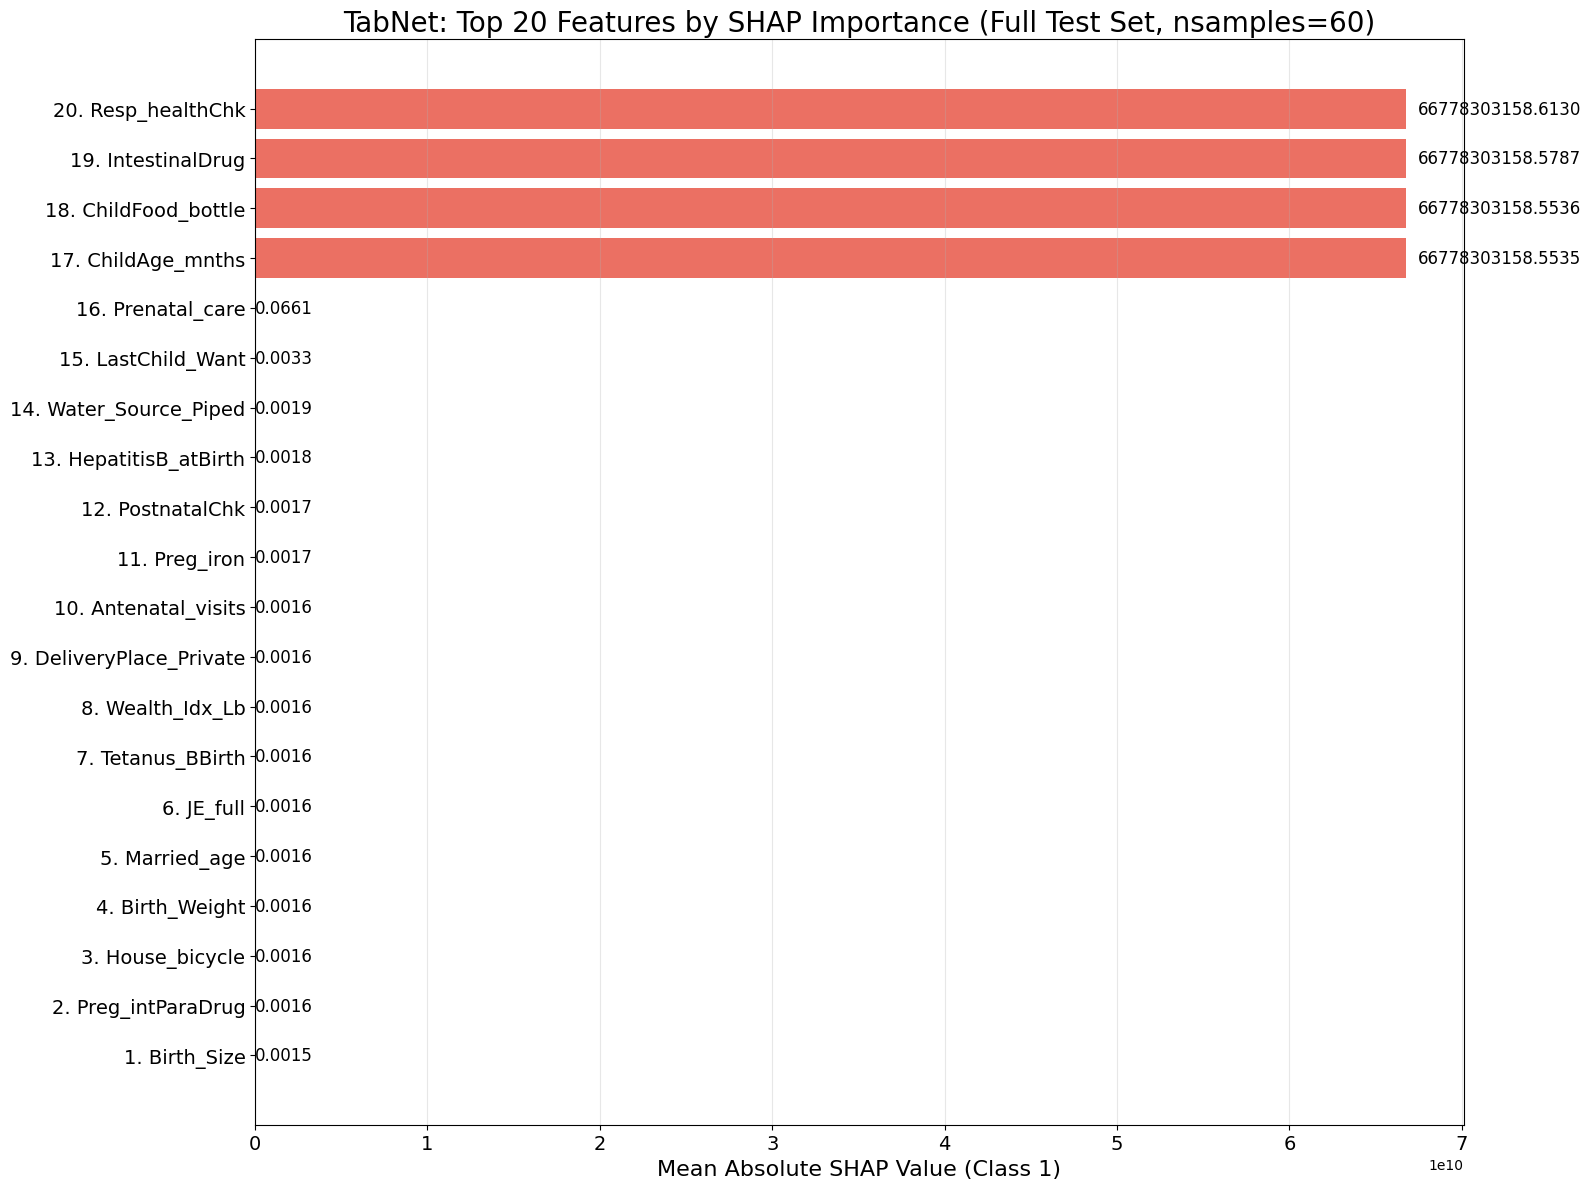

Saved: results/shap_plots/tabnet/tabnet_top_features_full_ns60.png

Generating TabNet SHAP Summary Plot...


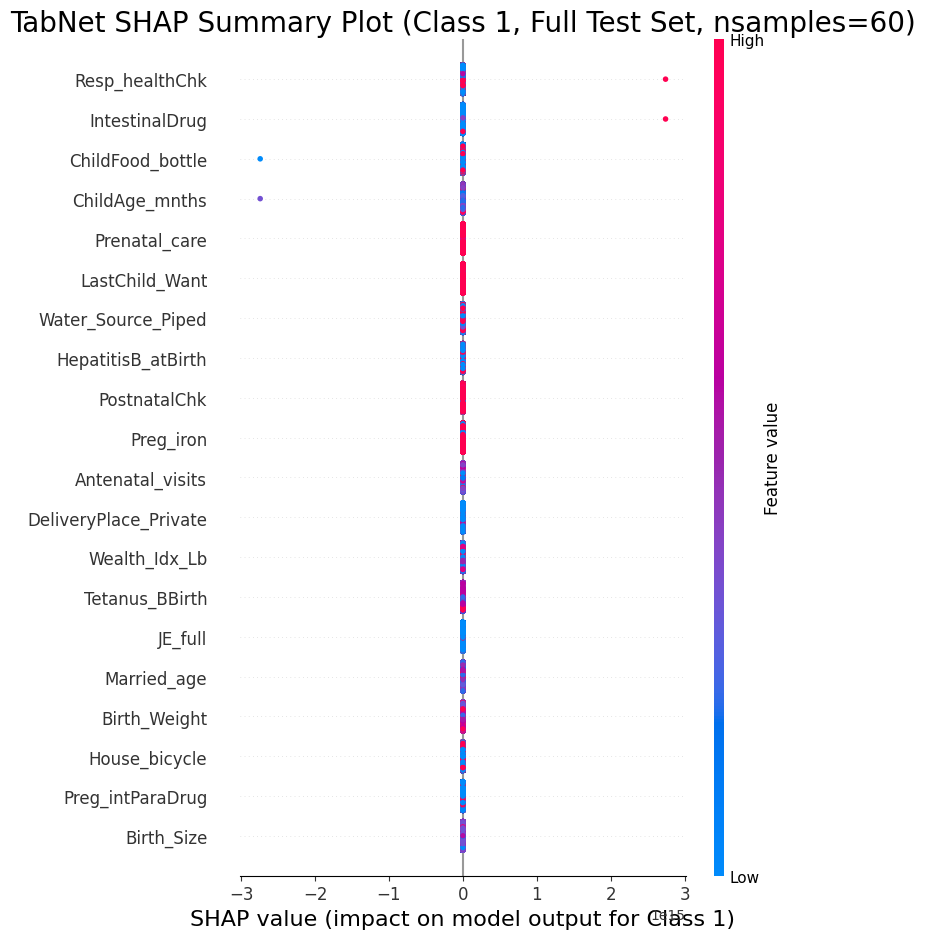

Saved: results/shap_plots/tabnet/tabnet_shap_summary_full_ns60.png

Generating TabNet waterfall plot for sample index 0...


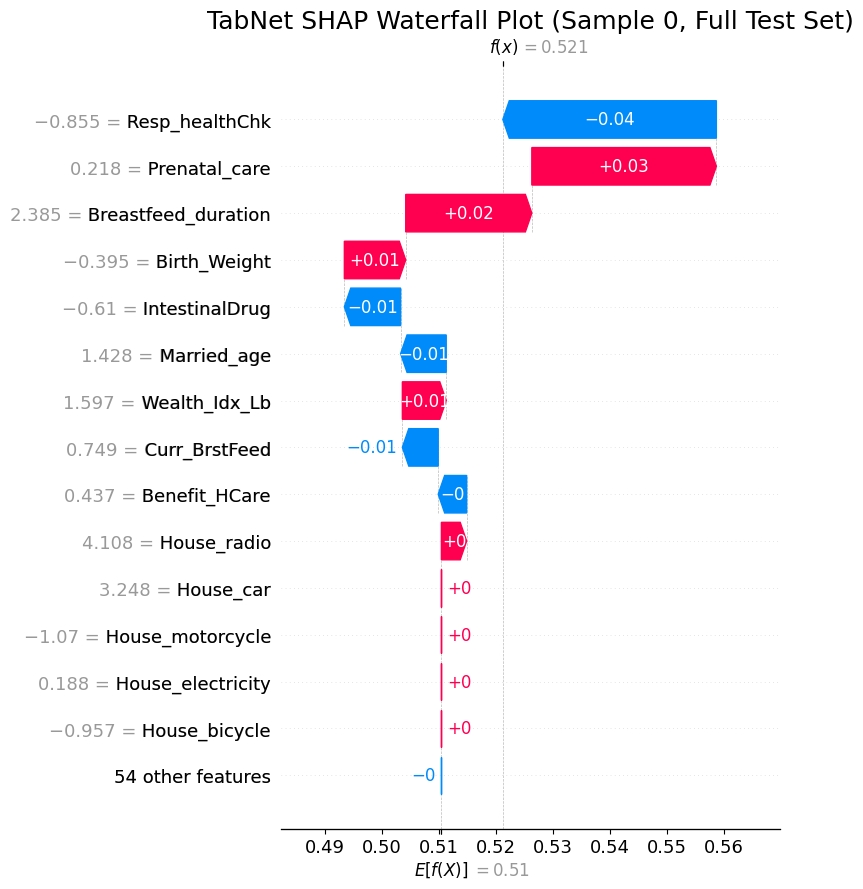

Saved: results/shap_plots/tabnet/tabnet_waterfall_sample_0_full_ns60.png

Generating TabNet Class Comparison Heatmap...


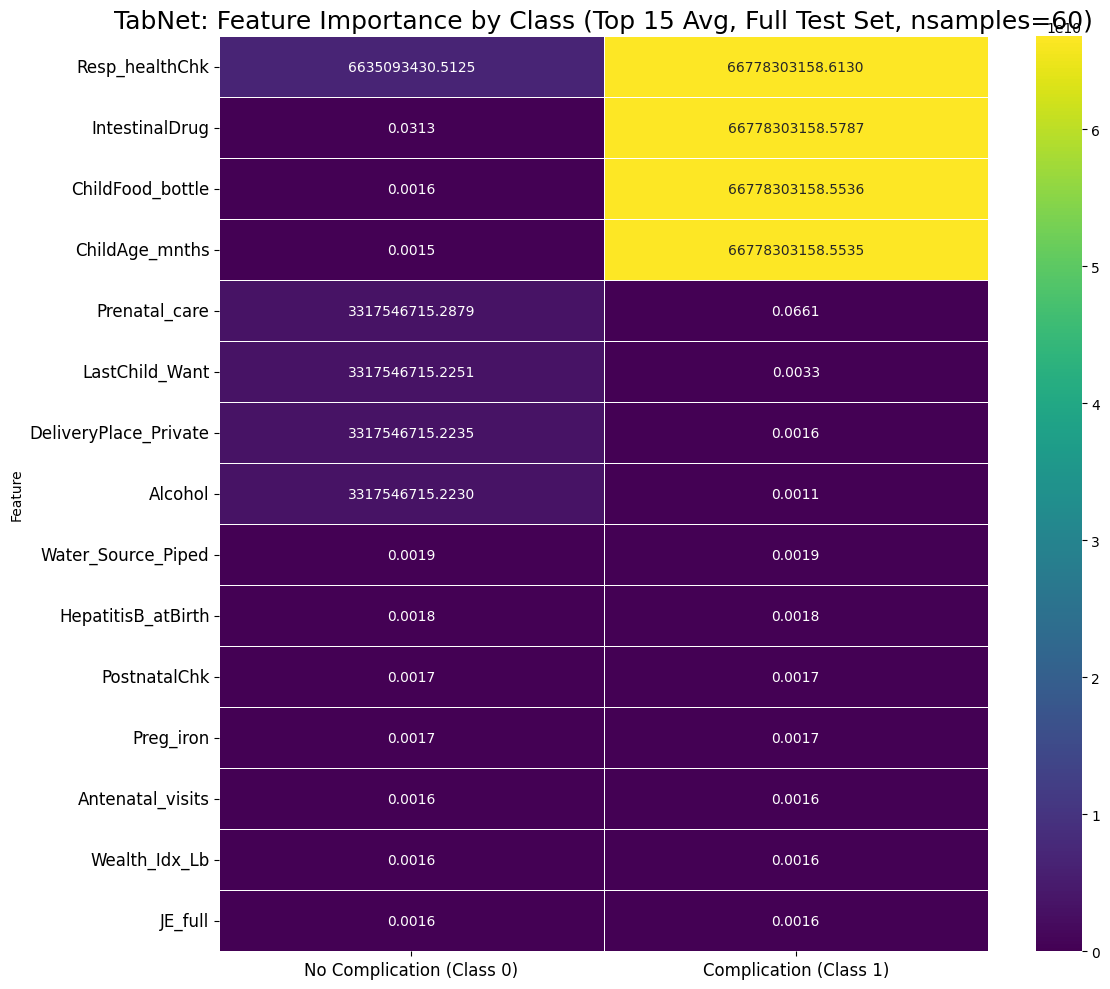

Saved: results/shap_plots/tabnet/tabnet_class_comparison_full_ns60.png

TabNet SHAP visualization generation complete (nsamples=60)!
Clearing memory...
Memory cleared.


In [ ]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import gc
import torch
import os
from torch import nn
import time 
from matplotlib.colors import Normalize

os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'
print("Set PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True")

tabnet_shap_dir = 'results/shap_plots/tabnet/' 
os.makedirs(tabnet_shap_dir, exist_ok=True)

def clear_memory():
    """Clears GPU cache and runs garbage collection."""
    print("Clearing memory...")
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    print("Memory cleared.")

print("\nChecking for necessary variables for TabNet SHAP...")
required_vars = ['model_tabnet', 'X_test', 'X_train', 'feature_names',
                 'cat_cols', 'num_cols', 'cat_feature_names', 'num_feature_names',
                 'split_cat_num', 'device']
variables_exist = True
for var in required_vars:
    if var not in globals():
        print(f"Error: Variable '{var}' not found. Please ensure previous steps were run or load data here.")
        variables_exist = False
if not variables_exist:
     raise NameError("Missing required variables for TabNet SHAP analysis.")
else:
    print("All necessary variables seem to exist.")

print("\nPreparing data and model for TabNet SHAP analysis...")

print("Preparing X_test and X_background in TabNet input format...")
X_test_cat, X_test_num = split_cat_num(X_test)
X_test_tabnet = np.concatenate([X_test_cat, X_test_num], axis=1).astype(np.float32)
n_samples_to_explain = X_test_tabnet.shape[0]
n_features = X_test_tabnet.shape[1]
print(f"Shape of X_test_tabnet (samples to explain): {X_test_tabnet.shape}")

n_background_samples = 50
if len(X_train) < n_background_samples: n_background_samples = len(X_train)
bg_indices = np.random.choice(len(X_train), n_background_samples, replace=False)
X_background_train_subset = X_train[bg_indices]
X_bg_cat, X_bg_num = split_cat_num(X_background_train_subset)
X_background_tabnet = np.concatenate([X_bg_cat, X_bg_num], axis=1).astype(np.float32)
print(f"Shape of X_background_tabnet: {X_background_tabnet.shape}")

if not isinstance(cat_feature_names, list): cat_feature_names = list(cat_feature_names)
if not isinstance(num_feature_names, list): num_feature_names = list(num_feature_names)
tabnet_feature_names = cat_feature_names + num_feature_names
print(f"Initial number of TabNet feature names: {len(tabnet_feature_names)}")

expected_features = n_features 
if len(tabnet_feature_names) != expected_features:
    print(f"Correcting feature name list length mismatch ({len(tabnet_feature_names)} vs {expected_features}).")
    num_missing = expected_features - len(tabnet_feature_names)
    for i in range(num_missing):
         if len(num_feature_names) == 0 and len(cat_feature_names) != 0 :
             tabnet_feature_names.append(f'dummy_numerical_{i}')
             print(f"Added dummy numerical feature name: dummy_numerical_{i}")
         elif len(cat_feature_names) == 0 and len(num_feature_names) != 0 :
              tabnet_feature_names.insert(0, f'dummy_categorical_{i}') 
              print(f"Added dummy categorical feature name: dummy_categorical_{i}")
         else:
             tabnet_feature_names.append(f'unknown_feature_{i}') 
             print(f"Added unknown placeholder feature name: unknown_feature_{i}")

print(f"Final number of TabNet feature names: {len(tabnet_feature_names)}")
if len(tabnet_feature_names) != n_features:
     print(f"FATAL WARNING: Final length of feature names ({len(tabnet_feature_names)}) still does not match data features ({n_features}). Visualization will likely fail.")


# TabNet 
def tabnet_predict_proba_shap(X):
    """ Prediction wrapper specifically for TabNet model. """
    X_float = X.astype(np.float32)
    try:
        probs = model_tabnet.predict_proba(X_float)
        return probs
    except Exception as e: print(f"Error during model_tabnet.predict_proba: {e}"); raise e
print("Prediction wrapper for TabNet SHAP defined.")

clear_memory()
print("\n" + "="*50); print("CALCULATING TABNET SHAP VALUES (Full Test Set, nsamples=60)"); print("="*50)

explicit_nsamples = 60
print(f"Using KernelExplainer with {X_background_tabnet.shape[0]} background samples.")
print(f"Explaining ALL {n_samples_to_explain} instances in X_test_tabnet.")
print(f"Explicitly setting nsamples = {explicit_nsamples} (Reduced drastically for <1hr runtime).")
print("WARNING: SHAP values accuracy will be limited due to low nsamples.")
print("Estimated runtime ~1 hour or less...")

start_time = time.time()
calculation_successful = False; shape_ok = False
shap_output = None

try:
    tabnet_explainer = shap.KernelExplainer(tabnet_predict_proba_shap, X_background_tabnet)
    shap_output = tabnet_explainer.shap_values(X_test_tabnet, nsamples=explicit_nsamples)
    calculation_successful = True
except torch.cuda.OutOfMemoryError:
     print("\n" + "*"*60); print("ERROR: CUDA Out Of Memory occurred."); print(f"Even nsamples={explicit_nsamples} might be too high if TabNet is memory intensive."); print("Consider partitioning or CPU."); print("*"*60)
except Exception as e:
    print(f"\nError during TabNet SHAP calculation: {e}")

tabnet_shap_values_class0 = None
tabnet_shap_values_class1 = None

if calculation_successful:
    end_time = time.time()
    print(f"TabNet SHAP calculation complete in {end_time - start_time:.2f} seconds ({ (end_time - start_time)/60 :.2f} minutes).")

    print("\n--- Processing SHAP Output ---")
    try:
        if isinstance(shap_output, np.ndarray) and shap_output.ndim == 3:
            print(f"Detected NumPy array output with shape: {shap_output.shape}")
            expected_shape_part = (n_samples_to_explain, n_features)
            if shap_output.shape[0:2] == expected_shape_part and shap_output.shape[2] == 2:
                print("Shape matches (samples, features, 2 classes). Slicing...")
                tabnet_shap_values_class0 = shap_output[:, :, 0]
                tabnet_shap_values_class1 = shap_output[:, :, 1]
                print(f"Shape of extracted tabnet_shap_values_class0: {tabnet_shap_values_class0.shape}")
                print(f"Shape of extracted tabnet_shap_values_class1: {tabnet_shap_values_class1.shape}")
                shape_ok = True
            else: print(f"ERROR: NumPy array shape {shap_output.shape} mismatch expected ({n_samples_to_explain}, {n_features}, 2).")
        elif isinstance(shap_output, list) and len(shap_output) == 2:
             print("Detected list output."); expected_shape=(n_samples_to_explain,n_features)
             if shap_output[0].shape == expected_shape and shap_output[1].shape == expected_shape:
                 print("List shapes OK."); tabnet_shap_values_class0 = shap_output[0]; tabnet_shap_values_class1 = shap_output[1]; shape_ok = True
             else: print(f"ERROR: List elements have unexpected shapes: {shap_output[0].shape}, {shap_output[1].shape}")
        else: print(f"ERROR: Unexpected output type/structure: {type(shap_output)}")
    except Exception as e: print(f"Error processing SHAP output: {e}")
    print("--- End Processing ---")
    clear_memory()

if calculation_successful and shape_ok and tabnet_shap_values_class1 is not None:

    print("\n" + "="*50); print("GENERATING TABNET SHAP VISUALIZATIONS"); print("="*50)
    current_nsamples = explicit_nsamples
    print(f"Note: Visualizations based on nsamples={current_nsamples} on the full test set.")

    dataframe_creation_successful = False; importance_calculated = False
    try:
        print(f"Calculating feature importance from tabnet_shap_values_class1 with shape: {tabnet_shap_values_class1.shape}")
        tabnet_feature_importance = np.abs(tabnet_shap_values_class1).mean(axis=0)
        importance_calculated = True
        print(f"Shape of calculated tabnet_feature_importance: {tabnet_feature_importance.shape}")
        print(f"Length of tabnet_feature_names: {len(tabnet_feature_names)}") # Use corrected names
        print(f"Length of tabnet_feature_importance: {len(tabnet_feature_importance)}")

        if len(tabnet_feature_names) == len(tabnet_feature_importance):
            tabnet_importance_df = pd.DataFrame({'Feature': tabnet_feature_names, 'Importance': tabnet_feature_importance})
            dataframe_creation_successful = True; print("DataFrame created successfully.")
        else: print("ERROR: Length mismatch. Cannot create DataFrame.")
    except Exception as e: print(f"\nError during importance calculation or DataFrame creation: {e}")

    if dataframe_creation_successful:
        tabnet_importance_df = tabnet_importance_df.sort_values('Importance', ascending=False).reset_index(drop=True)
        print("\nTabNet: Top 20 Features by SHAP Importance (Full Test Set):")
        print(tabnet_importance_df.head(20))
        top_n = min(20, len(tabnet_importance_df))
        tabnet_top_features = tabnet_importance_df['Feature'].head(top_n).tolist()

        file_suffix = f"_full_ns{current_nsamples}"

        # 1. Feature importance bar plot (TabNet)
        plt.figure(figsize=(16, 12))
        bars = plt.barh(np.arange(top_n), tabnet_importance_df['Importance'].head(top_n)[::-1], color='#e74c3c', alpha=0.8) # Red color
        labels = [f"{i+1}. {f}" for i, f in enumerate(tabnet_importance_df['Feature'].head(top_n)[::-1])]
        plt.yticks(np.arange(top_n), labels, fontsize=14)
        for i, bar in enumerate(bars): plt.text(bar.get_width() + bar.get_width()*0.01, bar.get_y()+bar.get_height()/2, f"{tabnet_importance_df['Importance'].head(top_n)[::-1].iloc[i]:.4f}", va='center', fontsize=12)
        plt.title(f'TabNet: Top {top_n} Features by SHAP Importance (Full Test Set, nsamples={current_nsamples})', fontsize=20)
        plt.xlabel('Mean Absolute SHAP Value (Class 1)', fontsize=16); plt.xticks(fontsize=14); plt.grid(axis='x', alpha=0.3); plt.tight_layout()
        save_path = os.path.join(tabnet_shap_dir, f'tabnet_top_features{file_suffix}.png')
        plt.savefig(save_path, dpi=300, bbox_inches='tight'); plt.show()
        print(f"Saved: {save_path}")

        # 2. SHAP summary plot (TabNet)
        if tabnet_shap_values_class1.shape == (n_samples_to_explain, n_features):
            print("\nGenerating TabNet SHAP Summary Plot...")
            plt.figure()
            shap.summary_plot(tabnet_shap_values_class1, X_test_tabnet, feature_names=tabnet_feature_names, max_display=top_n, plot_type="dot", show=False, color_bar=True) # Use X_test_tabnet
            plt.title(f'TabNet SHAP Summary Plot (Class 1, Full Test Set, nsamples={current_nsamples})', fontsize=20)
            plt.xlabel('SHAP value (impact on model output for Class 1)', fontsize=16); plt.yticks(fontsize=12); plt.xticks(fontsize=12); plt.tight_layout()
            save_path = os.path.join(tabnet_shap_dir, f'tabnet_shap_summary{file_suffix}.png')
            plt.savefig(save_path, dpi=300, bbox_inches='tight'); plt.show()
            print(f"Saved: {save_path}")
        else: print(f"Skipping Summary plot due to unexpected shape: {tabnet_shap_values_class1.shape}")

        # 3. Waterfall plot (TabNet)
        sample_idx_waterfall = 0
        print(f"\nGenerating TabNet waterfall plot for sample index {sample_idx_waterfall}...")
        try:
             if hasattr(tabnet_explainer, 'expected_value') and isinstance(tabnet_explainer.expected_value, (list, np.ndarray)) and len(tabnet_explainer.expected_value) == 2:
                  tabnet_expected_value_class1 = tabnet_explainer.expected_value[1]; can_plot_waterfall = True
             else: print(f"Could not plot waterfall: explainer.expected_value missing/unexpected: {getattr(tabnet_explainer, 'expected_value', 'Not Found')}"); can_plot_waterfall = False

             if can_plot_waterfall and tabnet_shap_values_class1.shape == (n_samples_to_explain, n_features):
                 if sample_idx_waterfall < X_test_tabnet.shape[0]: # Check index validity
                     # Use X_test_tabnet for data
                     explanation_obj = shap.Explanation(values=tabnet_shap_values_class1[sample_idx_waterfall,:], base_values=tabnet_expected_value_class1, data=X_test_tabnet[sample_idx_waterfall,:], feature_names=tabnet_feature_names)
                     plt.figure(); shap.waterfall_plot(explanation_obj, max_display=15, show=False)
                     plt.title(f'TabNet SHAP Waterfall Plot (Sample {sample_idx_waterfall}, Full Test Set)', fontsize=18); plt.tight_layout()
                     save_path = os.path.join(tabnet_shap_dir, f'tabnet_waterfall_sample_{sample_idx_waterfall}{file_suffix}.png')
                     plt.savefig(save_path, dpi=300, bbox_inches='tight'); plt.show()
                     print(f"Saved: {save_path}")
                 else: print(f"Skipping waterfall: sample index {sample_idx_waterfall} out of bounds.")
             elif can_plot_waterfall: print(f"Skipping Waterfall plot due to unexpected shape: {tabnet_shap_values_class1.shape}")
        except Exception as e: print(f"Could not generate waterfall plot for sample {sample_idx_waterfall}: {e}")

        # 4. Feature importance heatmap (TabNet)
        print("\nGenerating TabNet Class Comparison Heatmap...")
        try:
            if tabnet_shap_values_class0 is not None and tabnet_shap_values_class0.shape == (n_samples_to_explain, n_features):
                tabnet_class0_importance = np.abs(tabnet_shap_values_class0).mean(axis=0); heatmap_possible = True
            else: print(f"Cannot generate heatmap: SHAP values class 0 missing/wrong shape ({tabnet_shap_values_class0.shape if tabnet_shap_values_class0 is not None else 'None'})."); heatmap_possible = False

            if heatmap_possible and importance_calculated: # Need class 1 importance too
                fig_heatmap, ax_heatmap = plt.subplots(figsize=(12, 10))
                tabnet_class_comparison = pd.DataFrame({'Feature': tabnet_feature_names, 'No Complication (Class 0)': tabnet_class0_importance, 'Complication (Class 1)': tabnet_feature_importance})
                tabnet_class_comparison['Average'] = (tabnet_class_comparison['No Complication (Class 0)'] + tabnet_class_comparison['Complication (Class 1)']) / 2
                tabnet_class_comparison = tabnet_class_comparison.sort_values('Average', ascending=False)
                n_heatmap_features = min(15, len(tabnet_feature_names))
                tabnet_class_comparison_top = tabnet_class_comparison.head(n_heatmap_features).drop('Average', axis=1)
                heatmap_data_tabnet = tabnet_class_comparison_top.set_index('Feature')
                sns.heatmap(heatmap_data_tabnet, cmap='viridis', annot=True, fmt='.4f', linewidths=.5, ax=ax_heatmap, annot_kws={"size": 10})
                ax_heatmap.set_title(f'TabNet: Feature Importance by Class (Top {n_heatmap_features} Avg, Full Test Set, nsamples={current_nsamples})', fontsize=18)
                ax_heatmap.tick_params(axis='y', rotation=0, labelsize=12); ax_heatmap.tick_params(axis='x', labelsize=12); plt.tight_layout()
                save_path = os.path.join(tabnet_shap_dir, f'tabnet_class_comparison{file_suffix}.png')
                plt.savefig(save_path, dpi=300, bbox_inches='tight'); plt.show()
                print(f"Saved: {save_path}")
            elif not importance_calculated: print("Skipping heatmap: importance for class 1 missing.")
            else: print("Skipping heatmap: importance class 0 missing/wrong shape.")
        except Exception as e: print(f"Could not generate class comparison heatmap: {e}")

        print(f"\nTabNet SHAP visualization generation complete (nsamples={current_nsamples})!")
    else: 
         print("\nCould not generate visualizations because the importance DataFrame could not be created.")

else:
    print("\nSkipping SHAP processing and visualizations because TabNet SHAP calculation failed or produced unusable output.")

clear_memory()

#SHAP ANALYSIS: ENSEMBLE MODEL


GPU-OPTIMIZED ENSEMBLE SHAP ANALYSIS FOR HIGH ACCURACY

Selecting stratified sample of 5000 from 41077 test samples...
Class distribution in subset: [2500 2500]

Preparing background dataset...

COMPUTE TIME ESTIMATION
Estimated runtime: 56250.0 minutes
Estimated compute units: 7500.0 units
Available compute units: 50 units
Safety margin: -7450.0 units

Initiating GPU-optimized SHAP computation...
- Subset size: 5000 samples (stratified)
- nsamples: 300
- Background size: 100
- Batch size: 512


  0%|          | 0/5000 [00:00<?, ?it/s]

SHAP analysis completed in 11081.76 seconds (184.7 minutes)

GENERATING ENSEMBLE SHAP VISUALIZATIONS


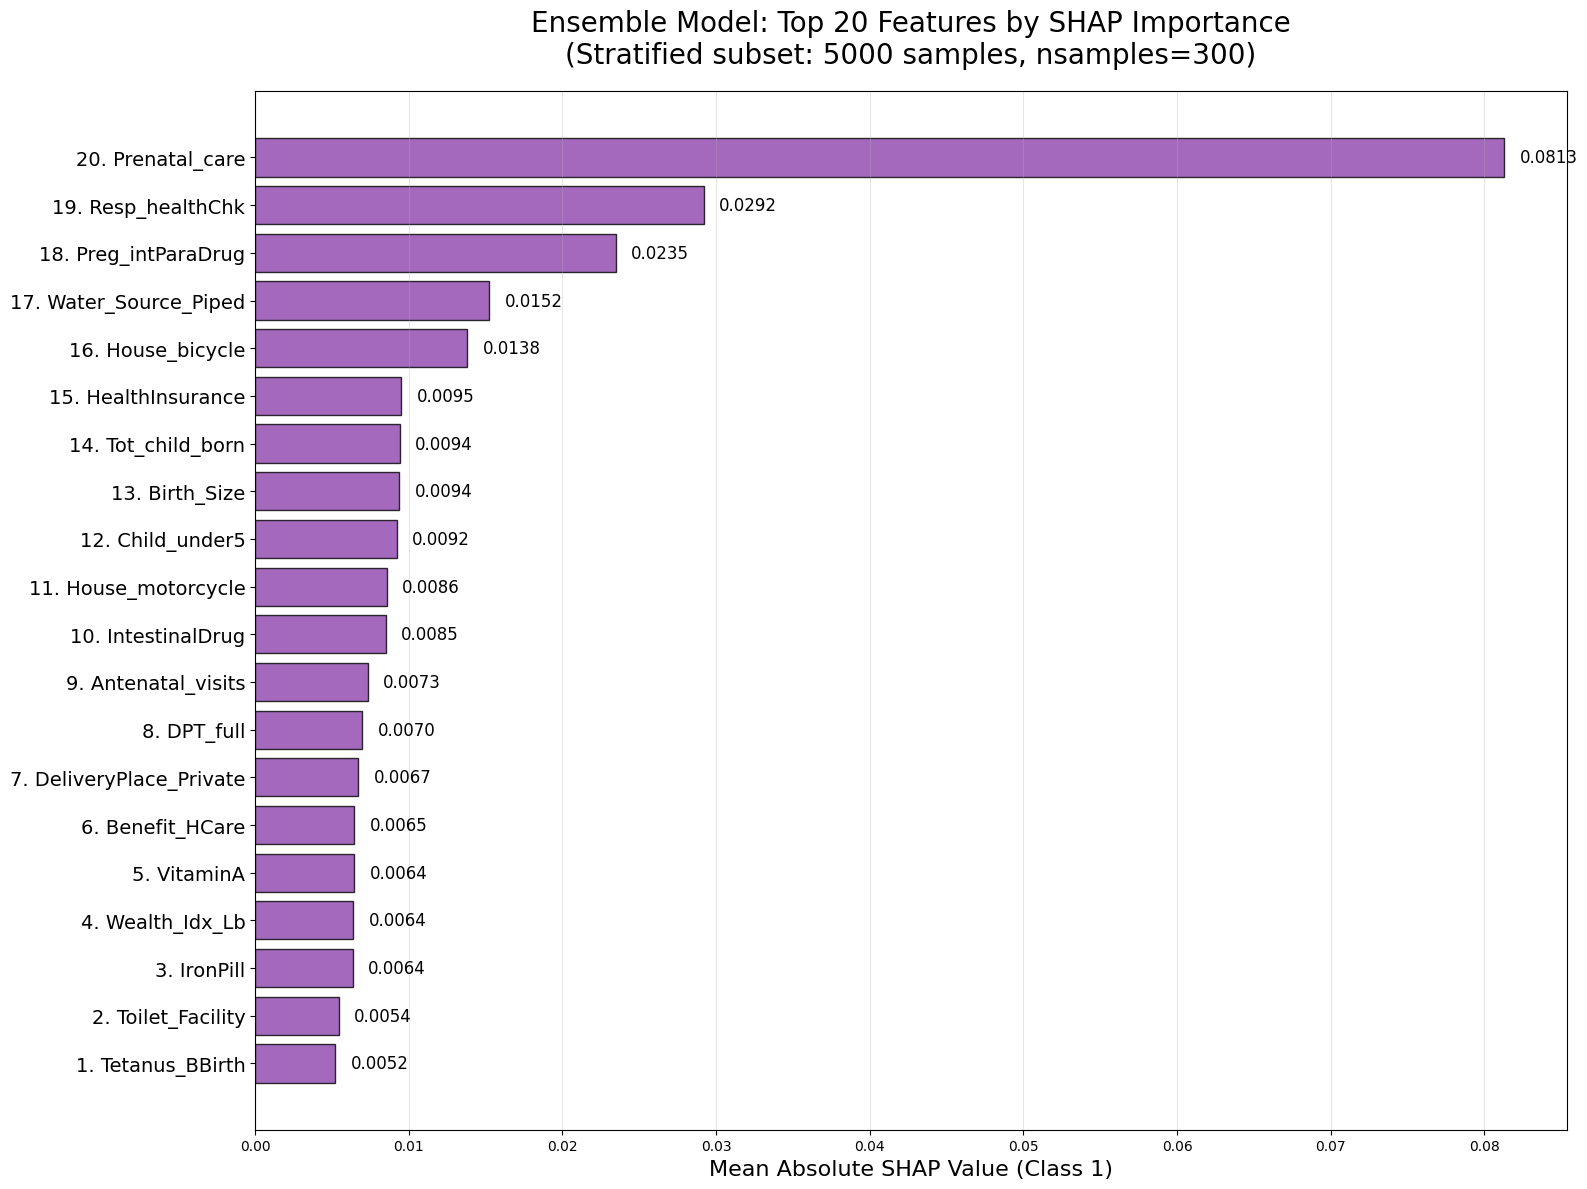

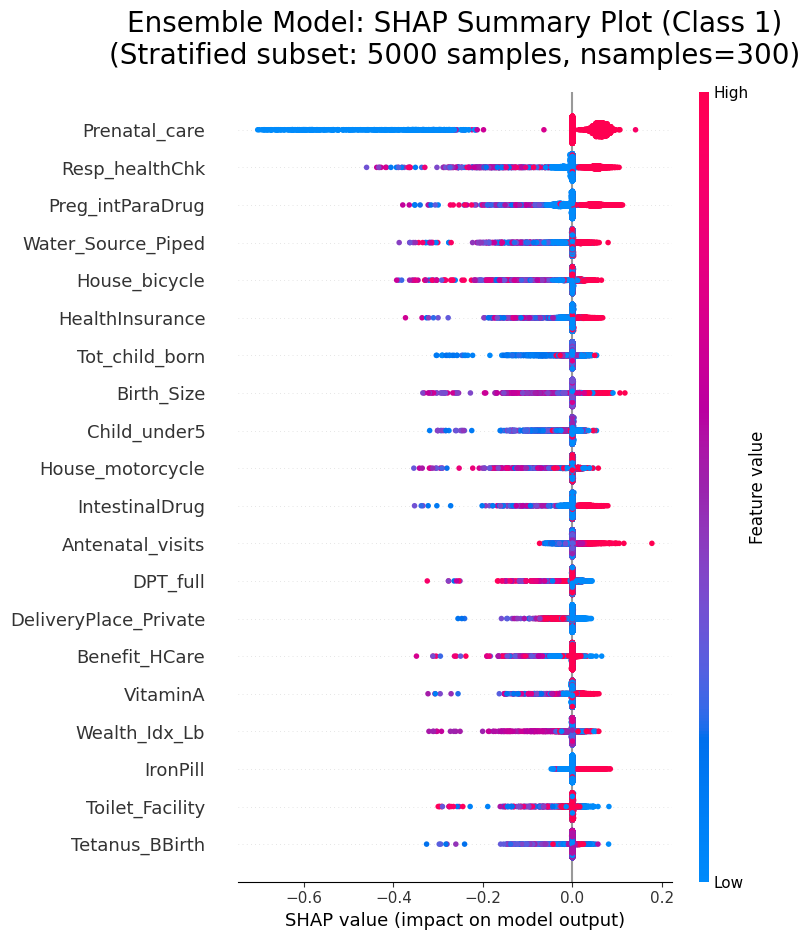

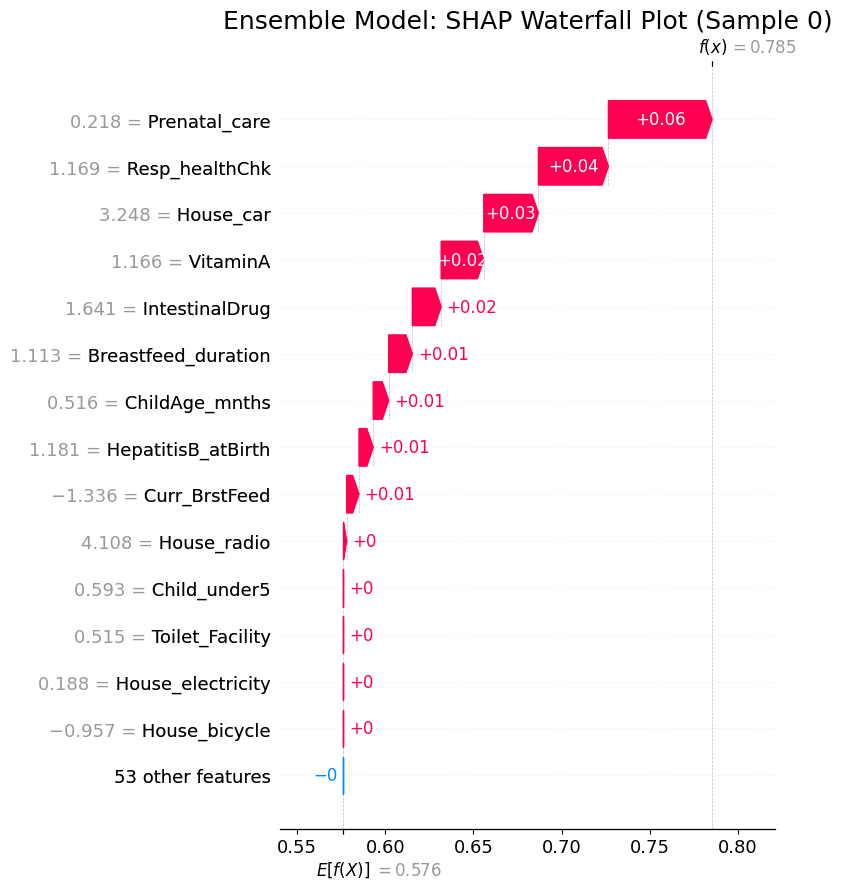

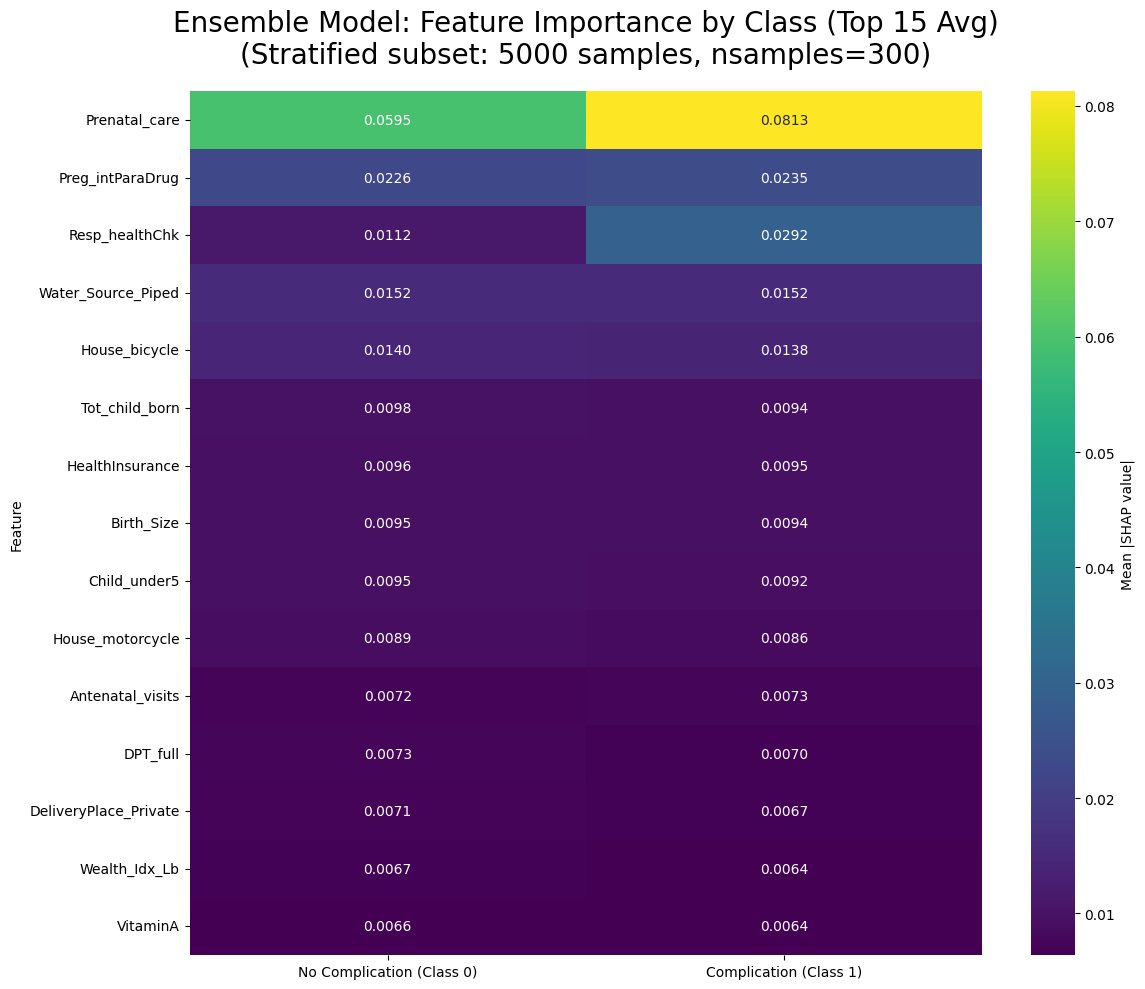

<Figure size 1600x1000 with 0 Axes>

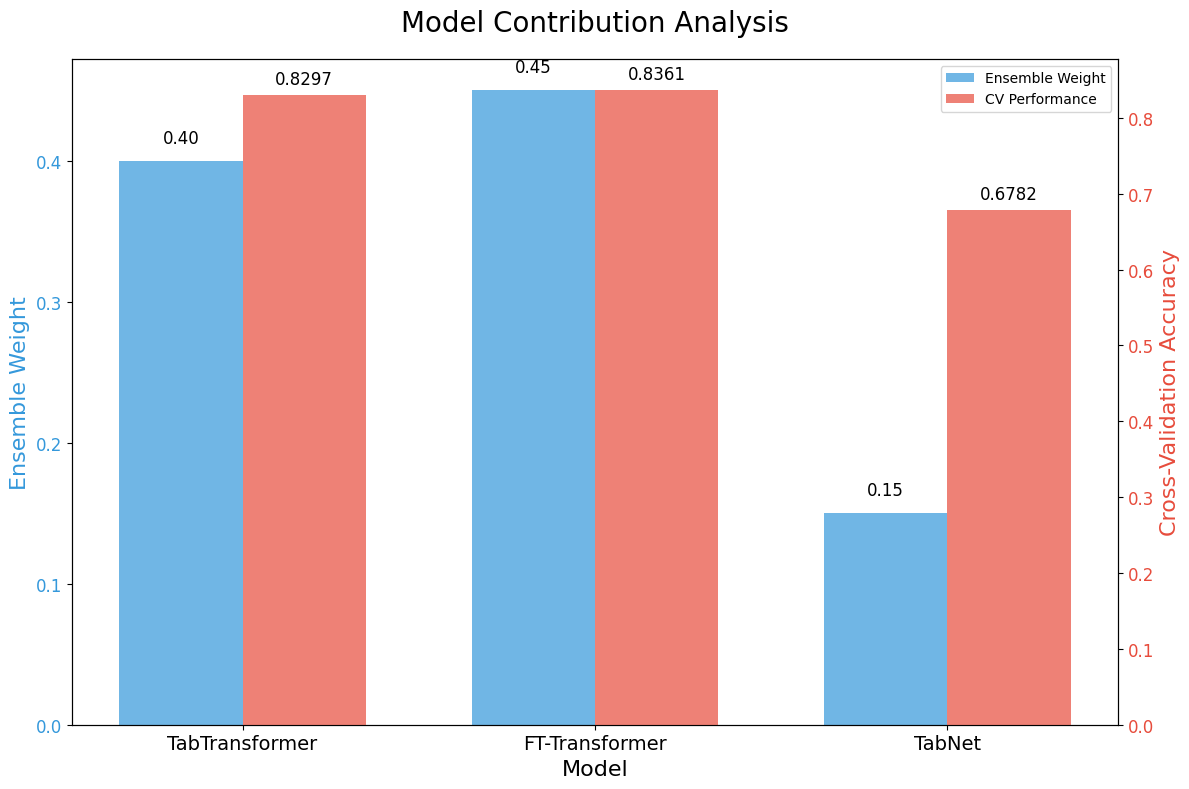

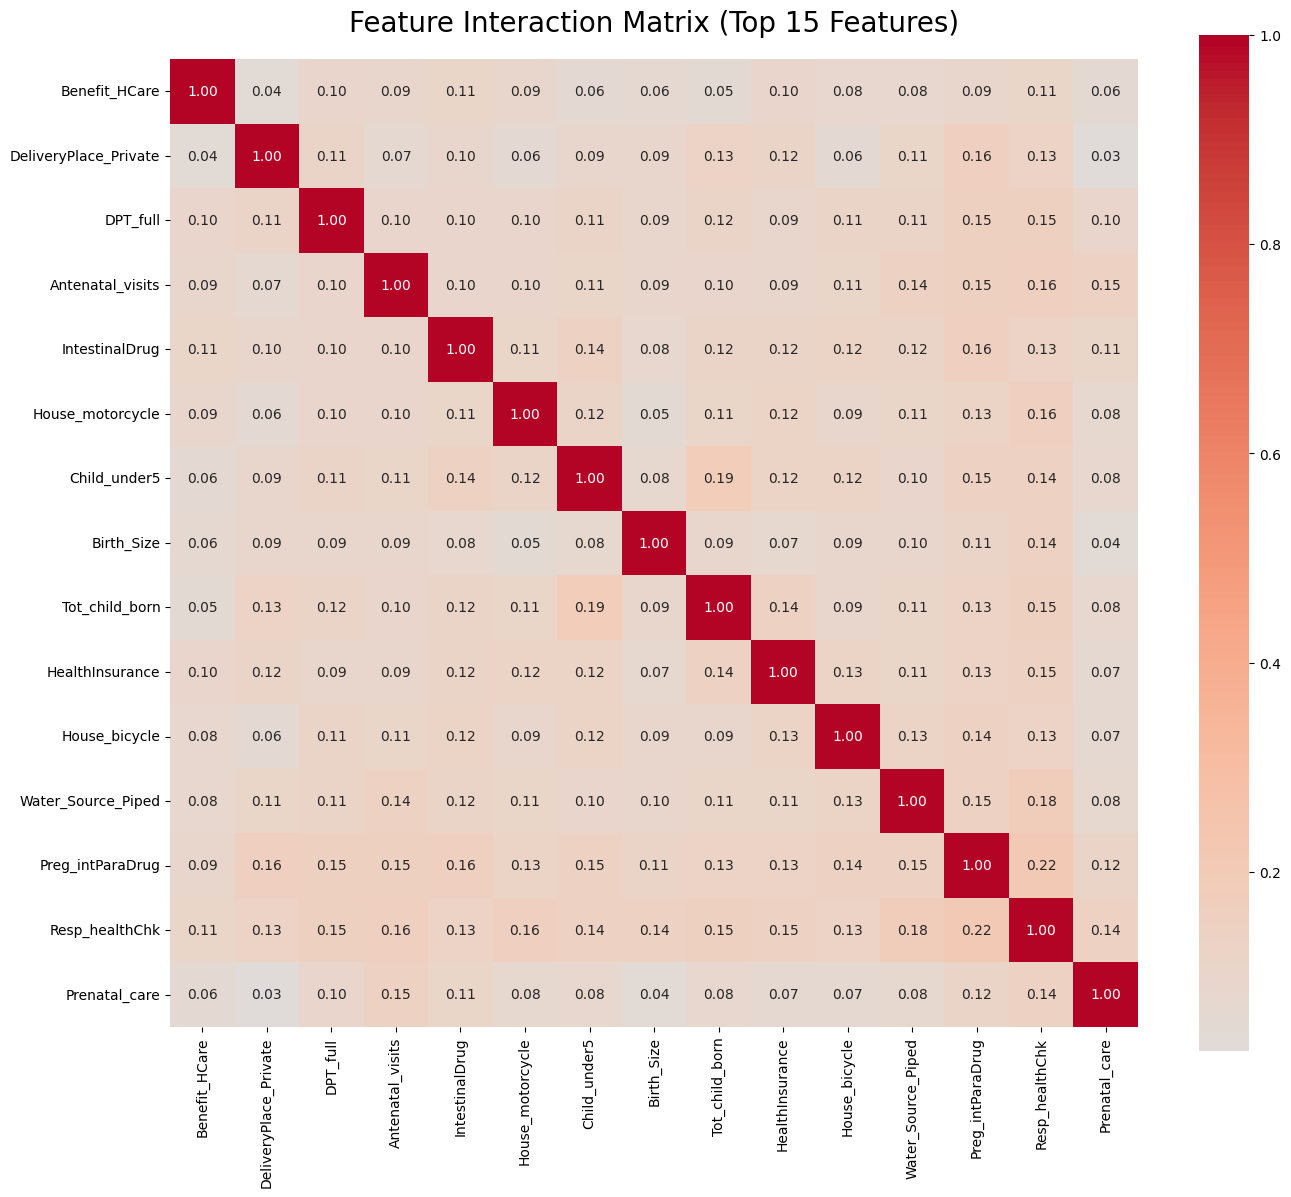

<Figure size 1000x600 with 0 Axes>

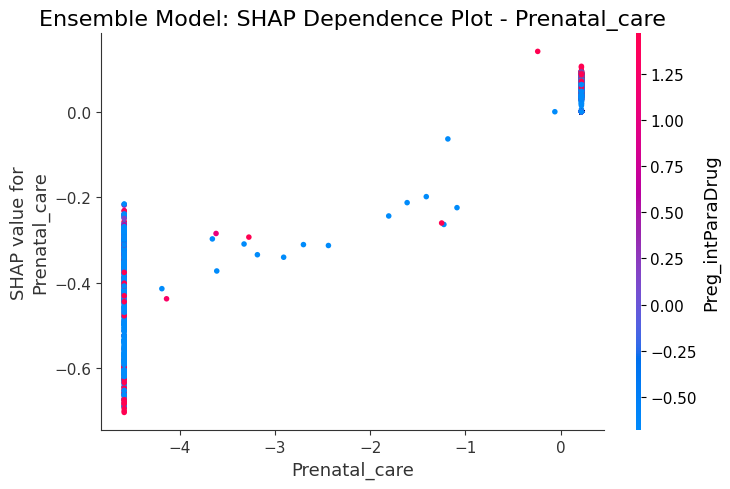

<Figure size 1000x600 with 0 Axes>

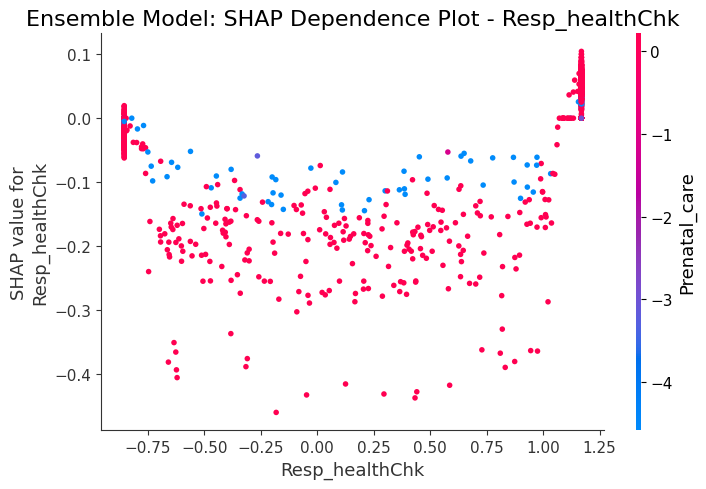

<Figure size 1000x600 with 0 Axes>

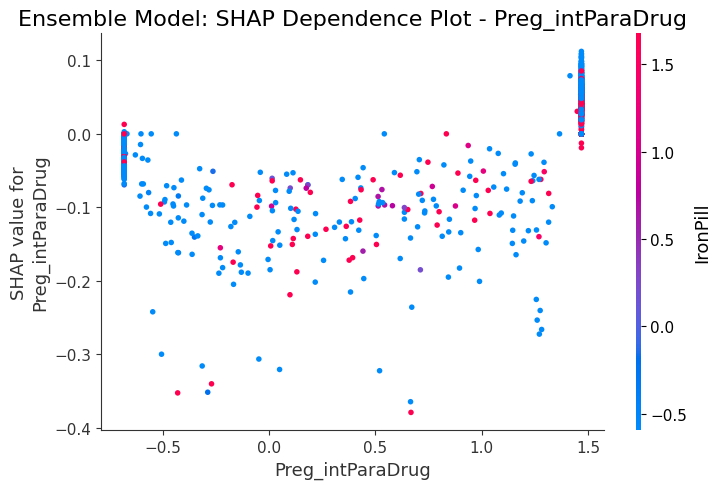

<Figure size 1000x600 with 0 Axes>

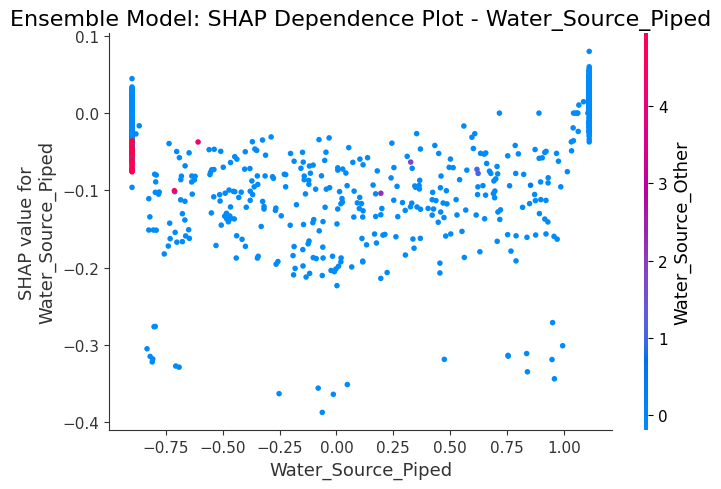

<Figure size 1000x600 with 0 Axes>

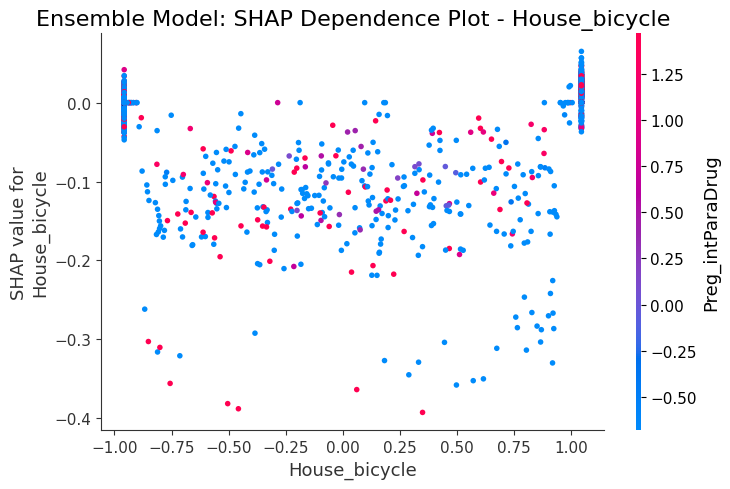

<Figure size 1400x800 with 0 Axes>

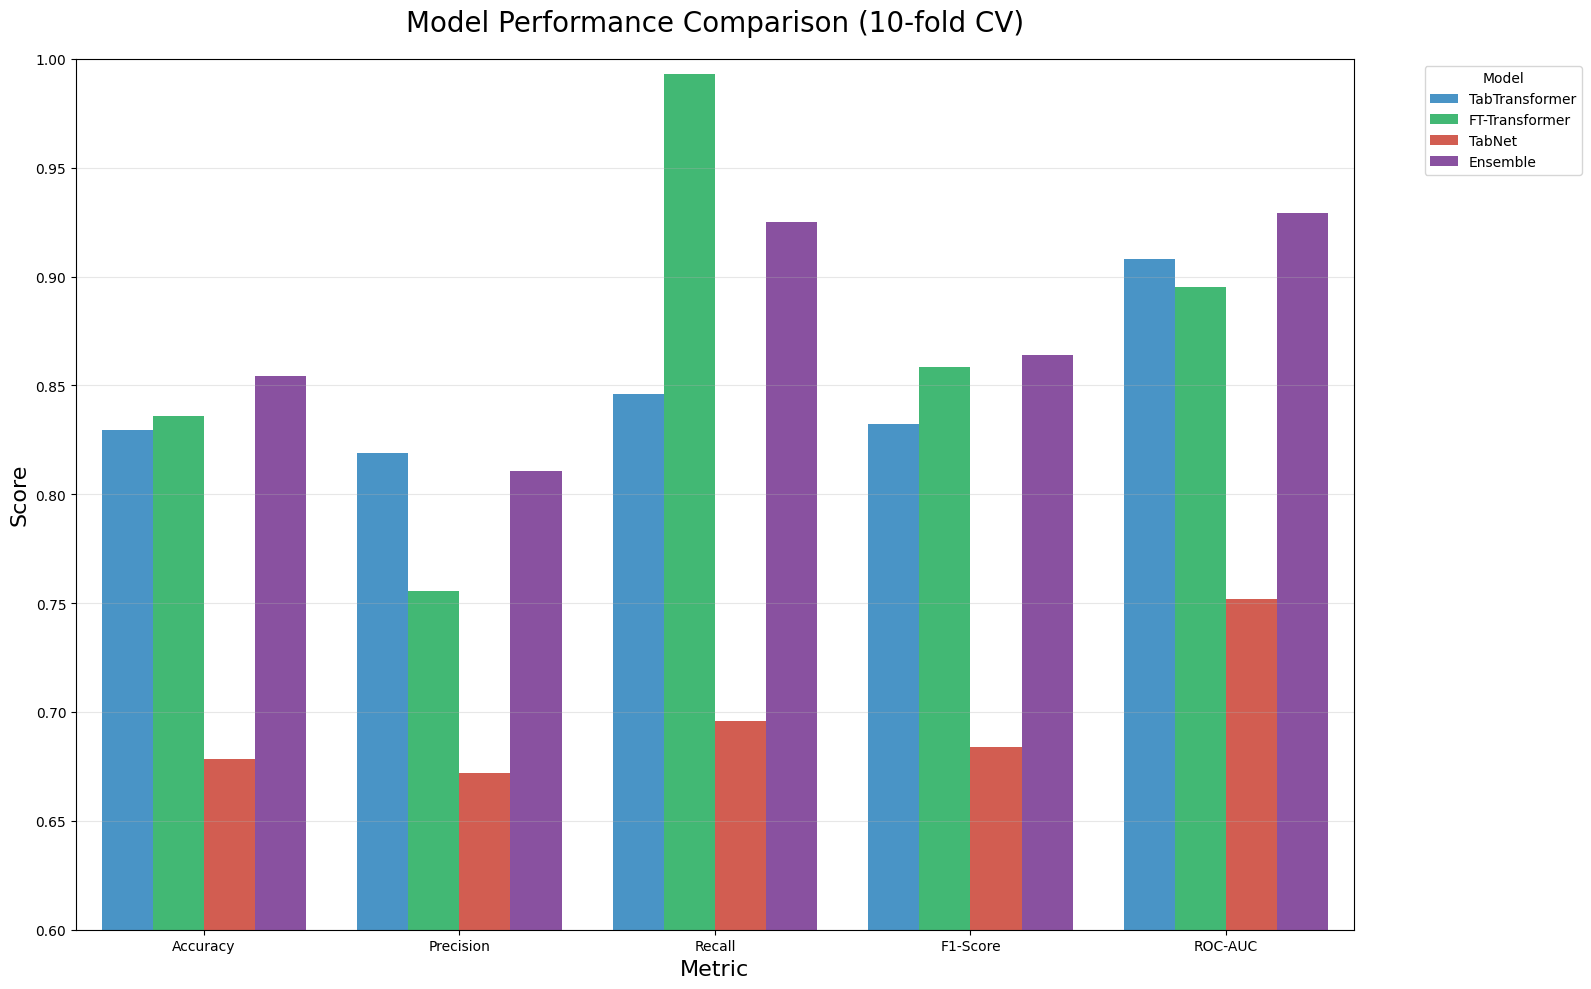


GPU-OPTIMIZED ENSEMBLE SHAP ANALYSIS COMPLETED SUCCESSFULLY
Results saved to: results/shap_plots/ensemble/
Total runtime: 184.7 minutes
Compute units used: 24.6
Processing speed: 27.1 samples/minute

Top 5 features by ensemble SHAP importance:
  56. Prenatal_care: 0.081280
  49. Resp_healthChk: 0.029200
  33. Preg_intParaDrug: 0.023470
  65. Water_Source_Piped: 0.015236
  5. House_bicycle: 0.013816


In [ ]:
# SHAP Analysis for Ensemble Model
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import gc
import pandas as pd
import os
from matplotlib.colors import Normalize
import time
from sklearn.model_selection import train_test_split
import torch

print("GPU-OPTIMIZED ENSEMBLE SHAP ANALYSIS FOR HIGH ACCURACY")

SUBSET_SIZE = 5000      
NSAMPLES = 300          
BACKGROUND_SIZE = 100
BATCH_SIZE = 512  
MAX_DISPLAY_FEATURES = 20

ensemble_shap_dir = 'results/shap_plots/ensemble/'
os.makedirs(ensemble_shap_dir, exist_ok=True)

if 'model_tab' not in globals() or 'model_ft' not in globals() or 'model_tabnet' not in globals():
    raise RuntimeError("Required model objects not found.")

print(f"\nSelecting stratified sample of {SUBSET_SIZE} from {len(X_test)} test samples...")
if hasattr(y_test, 'values'):
    y_test_array = y_test.values
else:
    y_test_array = y_test

X_test_subset, _, y_test_subset, _ = train_test_split(
    X_test, y_test_array,
    train_size=SUBSET_SIZE,
    stratify=y_test_array,
    random_state=42
)

print(f"Class distribution in subset: {np.bincount(y_test_subset.astype(int))}")

def ensemble_predict_proba_batch(X):
    """Batch-optimized prediction wrapper utilizing more GPU memory."""
    all_probs = []

    for i in range(0, len(X), BATCH_SIZE):
        batch = X[i:i+BATCH_SIZE]

        try:
            X_cat, X_num = split_cat_num(batch)
            X_cat_t = torch.tensor(X_cat, dtype=torch.long).to(device)
            X_num_t = torch.tensor(X_num, dtype=torch.float32).to(device)

            with torch.no_grad():
                tab_logits = model_tab(X_cat_t, X_num_t)
                ft_logits = model_ft(X_cat_t, X_num_t)

            tab_probs = torch.sigmoid(tab_logits).cpu().numpy()
            ft_probs = torch.sigmoid(ft_logits).cpu().numpy()

            # TabNet 
            X_tabnet = np.concatenate([X_cat, X_num], axis=1).astype(np.float32)
            tabnet_probs = model_tabnet.predict_proba(X_tabnet)

            weights = {
                'TabTransformer': 0.40,
                'FT-Transformer': 0.45,
                'TabNet': 0.15
            }

            # Aggregate predictions
            ensemble_probs = (weights['TabTransformer'] * tab_probs +
                             weights['FT-Transformer'] * ft_probs +
                             weights['TabNet'] * tabnet_probs)

            all_probs.append(ensemble_probs)

            if torch.cuda.is_available():
                torch.cuda.empty_cache()

        except Exception as e:
            print(f"Batch prediction error: {e}")
            raise

    return np.vstack(all_probs)

print("\nPreparing background dataset...")
bg_indices = np.random.choice(len(X_train), BACKGROUND_SIZE, replace=False)
X_background_ensemble = X_train[bg_indices]

print("COMPUTE TIME ESTIMATION")
estimated_time_minutes = (SUBSET_SIZE * NSAMPLES) / (60 / 2.25)
estimated_compute_units = (estimated_time_minutes / 60) * 8
print(f"Estimated runtime: {estimated_time_minutes:.1f} minutes")
print(f"Estimated compute units: {estimated_compute_units:.1f} units")
print(f"Available compute units: 50 units")
print(f"Safety margin: {50 - estimated_compute_units:.1f} units")

# SHAP value computation with GPU optimization
print(f"\nInitiating GPU-optimized SHAP computation...")
print(f"- Subset size: {SUBSET_SIZE} samples (stratified)")
print(f"- nsamples: {NSAMPLES}")
print(f"- Background size: {BACKGROUND_SIZE}")
print(f"- Batch size: {BATCH_SIZE}")
start_time = time.time()

try:
    # Use optimized batch prediction function
    ensemble_explainer = shap.KernelExplainer(ensemble_predict_proba_batch, X_background_ensemble)

    # Enable parallel processing
    ensemble_shap_values = ensemble_explainer.shap_values(
        X_test_subset,
        nsamples=NSAMPLES
    )
    computation_successful = True

except Exception as e:
    print(f"SHAP computation error: {e}")
    computation_successful = False

if computation_successful:
    end_time = time.time()
    print(f"SHAP analysis completed in {end_time - start_time:.2f} seconds ({(end_time - start_time)/60:.1f} minutes)")

    if isinstance(ensemble_shap_values, list) and len(ensemble_shap_values) == 2:
        ensemble_shap_class1 = ensemble_shap_values[1]
        ensemble_shap_class0 = ensemble_shap_values[0]
    elif isinstance(ensemble_shap_values, np.ndarray) and ensemble_shap_values.ndim == 3:
        ensemble_shap_class1 = ensemble_shap_values[:, :, 1]
        ensemble_shap_class0 = ensemble_shap_values[:, :, 0]
    else:
        raise ValueError("Unexpected SHAP output format")

    # Visualization Generation Phase
    print("GENERATING ENSEMBLE SHAP VISUALIZATIONS")

    # 1. Feature importance analysis
    feature_importance = np.abs(ensemble_shap_class1).mean(axis=0)
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': feature_importance
    }).sort_values('Importance', ascending=False)

    # Feature importance visualization (similar to FT-Transformer)
    plt.figure(figsize=(16, 12))
    top_features = importance_df.head(MAX_DISPLAY_FEATURES)
    bars = plt.barh(range(len(top_features)), top_features['Importance'][::-1],
                    color='#8e44ad', alpha=0.8, edgecolor='black')
    plt.yticks(range(len(top_features)),
               [f"{i+1}. {feat}" for i, feat in enumerate(top_features['Feature'][::-1])],
               fontsize=14)

    for i, v in enumerate(top_features['Importance'][::-1]):
        plt.text(v + 0.001, i, f'{v:.4f}', va='center', fontsize=12)

    plt.title(f'Ensemble Model: Top {MAX_DISPLAY_FEATURES} Features by SHAP Importance\n(Stratified subset: {SUBSET_SIZE} samples, nsamples={NSAMPLES})',
              fontsize=20, pad=20)
    plt.xlabel('Mean Absolute SHAP Value (Class 1)', fontsize=16)
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.savefig(f'{ensemble_shap_dir}ensemble_top_features.png', dpi=300, bbox_inches='tight')
    plt.show()

    # 2. SHAP summary plot
    plt.figure(figsize=(14, 10))
    shap.summary_plot(ensemble_shap_class1, X_test_subset, feature_names=feature_names,
                      max_display=MAX_DISPLAY_FEATURES, show=False)
    plt.title(f'Ensemble Model: SHAP Summary Plot (Class 1)\n(Stratified subset: {SUBSET_SIZE} samples, nsamples={NSAMPLES})',
              fontsize=20, pad=20)
    plt.tight_layout()
    plt.savefig(f'{ensemble_shap_dir}ensemble_shap_summary.png', dpi=300, bbox_inches='tight')
    plt.show()

    # 3. Waterfall plot
    sample_idx = 0
    plt.figure(figsize=(12, 8))
    shap.waterfall_plot(shap.Explanation(values=ensemble_shap_class1[sample_idx],
                                        base_values=ensemble_explainer.expected_value[1],
                                        data=X_test_subset[sample_idx],
                                        feature_names=feature_names),
                       max_display=15, show=False)
    plt.title(f'Ensemble Model: SHAP Waterfall Plot (Sample {sample_idx})', fontsize=18)
    plt.tight_layout()
    plt.savefig(f'{ensemble_shap_dir}ensemble_waterfall_sample_{sample_idx}.png', dpi=300, bbox_inches='tight')
    plt.show()

    # 4. Class comparison heatmap
    class0_importance = np.abs(ensemble_shap_class0).mean(axis=0)
    class1_importance = np.abs(ensemble_shap_class1).mean(axis=0)

    class_comparison = pd.DataFrame({
        'Feature': feature_names,
        'No Complication (Class 0)': class0_importance,
        'Complication (Class 1)': class1_importance
    })

    # Sort by average importance
    class_comparison['Average'] = (class_comparison['No Complication (Class 0)'] +
                                  class_comparison['Complication (Class 1)']) / 2
    class_comparison = class_comparison.sort_values('Average', ascending=False)
    top_comparison = class_comparison.head(15).drop('Average', axis=1)

    plt.figure(figsize=(12, 10))
    sns.heatmap(top_comparison.set_index('Feature'), annot=True, fmt='.4f',
                cmap='viridis', cbar_kws={'label': 'Mean |SHAP value|'})
    plt.title(f'Ensemble Model: Feature Importance by Class (Top 15 Avg)\n(Stratified subset: {SUBSET_SIZE} samples, nsamples={NSAMPLES})',
              fontsize=20, pad=20)
    plt.tight_layout()
    plt.savefig(f'{ensemble_shap_dir}ensemble_class_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

    # 5. Model contribution analysis
    plt.figure(figsize=(16, 10))
    model_contributions = pd.DataFrame({
        'Model': ['TabTransformer', 'FT-Transformer', 'TabNet'],
        'Weight': [0.40, 0.45, 0.15],
        'Performance': [0.8297, 0.8361, 0.6782]
    })

    fig, ax1 = plt.subplots(figsize=(12, 8))
    ax2 = ax1.twinx()

    x = np.arange(len(model_contributions))
    width = 0.35

    bars1 = ax1.bar(x - width/2, model_contributions['Weight'], width,
                    label='Ensemble Weight', color='#3498db', alpha=0.7)
    bars2 = ax2.bar(x + width/2, model_contributions['Performance'], width,
                    label='CV Performance', color='#e74c3c', alpha=0.7)

    for i, (w, p) in enumerate(zip(model_contributions['Weight'], model_contributions['Performance'])):
        ax1.text(i - width/2, w + 0.01, f'{w:.2f}', ha='center', va='bottom', fontsize=12)
        ax2.text(i + width/2, p + 0.01, f'{p:.4f}', ha='center', va='bottom', fontsize=12)

    ax1.set_xlabel('Model', fontsize=16)
    ax1.set_ylabel('Ensemble Weight', fontsize=16, color='#3498db')
    ax2.set_ylabel('Cross-Validation Accuracy', fontsize=16, color='#e74c3c')
    ax1.set_xticks(x)
    ax1.set_xticklabels(model_contributions['Model'], fontsize=14)
    ax1.tick_params(axis='y', labelsize=12, labelcolor='#3498db')
    ax2.tick_params(axis='y', labelsize=12, labelcolor='#e74c3c')

    plt.title('Model Contribution Analysis', fontsize=20, pad=20)
    fig.legend(loc='upper right', bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)
    fig.tight_layout()
    plt.savefig(f'{ensemble_shap_dir}model_contribution_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

    # 6. Feature interaction matrix
    plt.figure(figsize=(14, 12))
    interaction_matrix = np.corrcoef(ensemble_shap_class1.T)
    top_feature_indices = np.argsort(feature_importance)[-15:]
    top_feature_names = [feature_names[i] for i in top_feature_indices]

    sns.heatmap(interaction_matrix[np.ix_(top_feature_indices, top_feature_indices)],
                xticklabels=top_feature_names, yticklabels=top_feature_names,
                cmap='coolwarm', center=0, annot=True, fmt='.2f',
                annot_kws={'size': 10}, square=True)

    plt.title('Feature Interaction Matrix (Top 15 Features)', fontsize=20, pad=20)
    plt.tight_layout()
    plt.savefig(f'{ensemble_shap_dir}feature_interaction_matrix.png', dpi=300, bbox_inches='tight')
    plt.show()

    # 7. Dependence plots for top 5 features
    for i, feature in enumerate(importance_df['Feature'].head(5)):
        plt.figure(figsize=(10, 6))
        feature_idx = feature_names.index(feature)
        shap.dependence_plot(feature_idx, ensemble_shap_class1, X_test_subset,
                           feature_names=feature_names, show=False)
        plt.title(f'Ensemble Model: SHAP Dependence Plot - {feature}', fontsize=16)
        plt.tight_layout()
        plt.savefig(f'{ensemble_shap_dir}ensemble_dependence_{feature}.png', dpi=300, bbox_inches='tight')
        plt.show()

    # 8. Performance metrics comparison
    plt.figure(figsize=(14, 8))

    metrics_df = pd.DataFrame({
        'Model': ['TabTransformer', 'FT-Transformer', 'TabNet', 'Ensemble'],
        'Accuracy': [0.8297, 0.8361, 0.6782, 0.8545],
        'Precision': [0.8191, 0.7557, 0.6722, 0.8108],
        'Recall': [0.8462, 0.9932, 0.6957, 0.9249],
        'F1-Score': [0.8324, 0.8583, 0.6838, 0.8641],
        'ROC-AUC': [0.9079, 0.8951, 0.7521, 0.9290]
    })

    metrics_df_melted = metrics_df.melt(id_vars=['Model'], var_name='Metric', value_name='Score')

    plt.figure(figsize=(16, 10))
    sns.barplot(data=metrics_df_melted, x='Metric', y='Score', hue='Model',
                palette=['#3498db', '#2ecc71', '#e74c3c', '#8e44ad'])
    plt.title('Model Performance Comparison (10-fold CV)', fontsize=20, pad=20)
    plt.ylabel('Score', fontsize=16)
    plt.xlabel('Metric', fontsize=16)
    plt.ylim(0.6, 1.0)
    plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.savefig(f'{ensemble_shap_dir}model_performance_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Save results and computation details
    np.save(f'{ensemble_shap_dir}ensemble_shap_values.npy', ensemble_shap_values)
    importance_df.to_csv(f'{ensemble_shap_dir}ensemble_feature_importance.csv', index=False)

    # Save computation parameters
    computation_params = pd.DataFrame({
        'Parameter': ['Total test samples', 'Subset size', 'nsamples', 'Background size',
                     'Batch size', 'Runtime (minutes)', 'Compute units used',
                     'Class distribution (Class 0)', 'Class distribution (Class 1)'],
        'Value': [len(X_test), SUBSET_SIZE, NSAMPLES, BACKGROUND_SIZE, BATCH_SIZE,
                 f"{(end_time - start_time)/60:.1f}",
                 f"{((end_time - start_time)/3600) * 8:.1f}",
                 np.bincount(y_test_subset.astype(int))[0],
                 np.bincount(y_test_subset.astype(int))[1]]
    })
    computation_params.to_csv(f'{ensemble_shap_dir}computation_parameters.csv', index=False)

    print("GPU-OPTIMIZED ENSEMBLE SHAP ANALYSIS COMPLETED SUCCESSFULLY")
    print(f"Results saved to: {ensemble_shap_dir}")
    print(f"Total runtime: {(end_time - start_time)/60:.1f} minutes")
    print(f"Compute units used: {((end_time - start_time)/3600) * 8:.1f}")
    print(f"Processing speed: {SUBSET_SIZE/((end_time - start_time)/60):.1f} samples/minute")
    print(f"\nTop 5 features by ensemble SHAP importance:")
    for idx, row in importance_df.head(5).iterrows():
        print(f"  {idx+1}. {row['Feature']}: {row['Importance']:.6f}")

    # Memory cleanup
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

else:
    print("\nEnsemble SHAP analysis failed. Check error messages above.")